# Start

In [1]:
from numpy import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import numpy as np
import time
import torch as torch
from scipy.stats import norm
torch.set_printoptions(precision=8)
torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
torch.eye(2,3)

tensor([[1., 0., 0.],
        [0., 1., 0.]])

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
a_full = torch.randn(24, 24, dtype=torch.double, device='cuda')
b_full = torch.randn(24, 24, dtype=torch.double, device='cuda')
ab_full = a_full @ b_full
mean = ab_full.abs().mean()  # 80.7277

a = a_full.float()
b = b_full.float()
torch.backends.cuda.matmul.allow_tf32 = True
t1=time.time()
# Do matmul at TF32 mode.
ab_tf32 = a @ b  # takes 0.016s on GA100
error = (ab_tf32 - ab_full).abs().max()  # 0.1747
relative_error = error / mean  # 0.0022
t2=time.time()
# Do matmul with TF32 disabled.
torch.backends.cuda.matmul.allow_tf32 = False
ab_fp32 = a @ b  # takes 0.11s on GA100
error = (ab_fp32 - ab_full).abs().max()  # 0.0031
relative_error = error / mean  # 0.000039
t3=time.time()
t2-t1,t3-t2

(0.031075477600097656, 0.0004067420959472656)

In [ ]:
a  = torch.rand(3,3, 2, dtype=torch.double, device='cuda')
b  = torch.rand(2, 3, dtype=torch.double, device='cuda')

torch.mean(a,2),torch.max(a,2)

In [40]:
a=torch.ones(2,2,1,1,1)
b=torch.rand(3,3, 2)
(a*b).shape 

torch.Size([2, 2, 3, 3, 2])

In [23]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0")

# Version 1 $\mu$=1


Van der Pol oscillator
\begin{equation}
f(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
-x\left(x^{2}+y^{2}\right) \\
-y\left(x^{2}+y^{2}\right)
\end{array}\right]
\qquad
\partial f(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
-3x^{2}& -y^2 \\
 -x^2&-3y^{2}
\end{array}\right]
\end{equation}

Basic: 
 \begin{align}
d X_{t} &= \Big( v(X_{t},\mu_{t}^{X}) + b(t,X_{t}, \mu_{t}^{X})\Big)d t + \sigma(t,X_{t}, \mu_{t}^{X})d W_{t},  \quad X_{0} \in L_{0}^{m}( R^{d}),\\
v(x,\mu)&= u(x,\mu)+ \int_{R^{d}  } f(x-y) \mu(dy) 
,\qquad 
u(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
-\frac13 x^3 \\
0
\end{array}\right]
,
\qquad 
b(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
x-y \\
x
\end{array}\right]
,
\qquad
\sigma (\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
1+ x \\
y
\end{array}\right]
\end{align}

## Method

In [ ]:
def torch_make_brownian_motion(bm,h):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm), dtype=torch.float64, device='cuda')
    return(0)

def torch_make_brownian_motion_md(bm,h,d):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm),d, dtype=torch.float64, device='cuda')
    return(0)


def f3(a): #a: N x N x 2
    nn=len(a)
    result=(torch.sum(a**2,2).reshape(nn,nn,1))*a
    return(-torch.mean(result,1))
#     return(result)
    


def f3_tam(a,mma): #a: N x N x 2
    nn=len(a)
    result=(torch.sum(a**2,2).reshape(nn,nn,1))*a
    result=result/(1+mma*torch.abs(result))

    return(-torch.mean(result,1))

    

def df3(aa):
    nn=len(aa)
    dd=len(aa[0,0])
    df=torch.matmul(aa.reshape(nn,nn,dd,1),aa.reshape(nn,nn,1,dd))*(-2)
    _norm2=-torch.sum(aa**2,2).reshape(nn,nn,1)
    df+=_norm2.reshape(nn,nn,1,1)*torch.eye(dd)
    
    return(torch.mean(df,1))

def du3(aa):
    nn=len(aa)
    ddd=len(aa[0])
    df=torch.zeros((nn,ddd,ddd), dtype=torch.float64, device='cuda')   
    df[:,0,0]=-aa[:,0]**2
    return(df)


def sigma3(aa):
    sig=aa.detach().clone()
    return(sig)

def b3(aa):
    bb=aa.detach().clone()    
    return(bb)



def torch_ssm_method(x,bm,h,T,N):  #x : 2xNx2
    
    # N=len(x[0])
    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    mul_1=torch.tensor([1,-1])
    ddd=len(x[1,0])
    mul_2=torch.eye(ddd, dtype=torch.float64,  device='cuda')
    dd=len(x[1,0])
    
    bb_matrix=torch.tensor([[1.,-1.],[1.,0.]], dtype=torch.float64,  device='cuda'  )
    sig_matrix=torch.tensor([1.,0.] ,  dtype=torch.float64, device='cuda' )
    sig_y=torch.tensor([1.,1.] ,  dtype=torch.float64, device='cuda' )
    
    pd=True
    while pd:
        sample_vre = torch.reshape(y[1,:N],(N,1,dd))
        
        nominator_tmp = sample_vre-y[1,:N]
#         nom_tmp =  -nominator_tmp**3 
        
        vy =  f3(nominator_tmp)      
        
        uy = y.detach().clone()
        uy[1,:N,1]=0
        
        # FF=(vy*h-h*uy[1,:N]**3-y[1,:N]+x[1,:N])
        
        FF=(vy*h-(h/3*uy[1,:N]**3)-y[1,:N]+x[1,:N])
        
        d_f=df3(nominator_tmp)
        
        # d_uy= du3( uy[1,:N])
        # d_FF=h*(d_f+d_uy)-mul_2

        
        d_FF=h*(d_f)-mul_2
        d_FF[:,0,0]+=-uy[1,:N,0]**2*h

        inv_d_FF=torch.linalg.inv(d_FF)
        FF=FF.reshape(N,dd,1)
        
        inv_d_FF_x_FF=torch.matmul(inv_d_FF,FF)
        
        y[1,:N]+= -inv_d_FF_x_FF.reshape(N,dd)
        
        if torch.max(torch.abs(inv_d_FF_x_FF))<=sqrth:  
            pd=False
            #print( max(np.abs(fovergprime)) )
    
    sigg=sigma3(y[1,:N])
    
    
    dWt=bm[:N]-x[0,:N]
    x[0,:N]=bm[:N]
#     x[1,:N]=y[1,:N]+bb*h + sigg*dWt
    x[1,:N]=y[1,:N]+(torch.matmul(bb_matrix,y[1,:N].reshape(N,2,1))*h).reshape(N,2)+(sig_matrix+(sig_y*y[1:N]))*dWt
    return(0)



def torch_taming_method(x,bm,h,T,N):  #x : 2xNx2
    
    # N=len(x[0])
    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    mul_1=torch.tensor([1,-1])
    mul_2=torch.tensor([[1,0],[0,1]])
    mma=M**(-alpha)
    bb_matrix=torch.tensor([[1.,-1.],[1.,0.]], dtype=torch.float64,  device='cuda'  )
    sig_matrix=torch.tensor([1.,0.] ,  dtype=torch.float64, device='cuda' )
    sig_y=torch.tensor([1.,1.] ,  dtype=torch.float64, device='cuda' )
    
    sample_vre = torch.reshape(x[1,:N],(N,1,2))    
    nominator_tmp = sample_vre-x[1,:N]
    vx =  f3(nominator_tmp)
    
    
    vx[:,0]+=-x[1,:N,0]**3/3
    
    bx= b3( x[1,:N]  )
    
    sigmax=sigma3(  x[1,:N]   )
    
    dWt=bm[:N]-x[0,:N]
    x[0,:N]=bm[:N]
    sigx=(sig_matrix+(sig_y*x[1,:N]))
    x[1,:N]+=h*vx/(1+mma*torch.abs(vx))+(torch.matmul(bb_matrix,x[1,:N].reshape(N,2,1))*h).reshape(N,2)+(sigx)*dWt
    return(0)





In [ ]:
def torch_calculation_weak_error(exact,approx):
    n=len(exact[1])
    ex=torch.reshape(exact[1,:],(2*N,1))
    ap=torch.reshape(approx[1,:],(2*N,1))
    weak_error=abs(ex-ap)
    torch.mean(weak_error)
    return(torch.mean(weak_error).tolist())

def torch_calculation_strong_error(exact,approx):
    n=len(exact[1])
    ex=torch.reshape(exact[1,:],(2*N,1))
    ap=torch.reshape(approx[1,:],(2*N,1))
    strong_error=(ex-ap)**2
    return(np.sqrt(torch.mean(strong_error).tolist()))

## Strong error

In [ ]:
T=1
d=2
M=int(1e4)
h=1e-4
n_of_scheme=8
n=1000
N=n
round_scheme=10



timestep=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
moder=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
for i in range(len(moder)):
    moder[i]=int(moder[i]*(1e4))

nmoder=len(moder)



#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

time_ssm=np.zeros(nmoder)
time_tam=np.zeros(nmoder)

particle_taming_method1=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_taming_method2=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_split_step_method1=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_split_step_method2=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_euler_method=torch.zeros(nmoder,2,N,2, dtype=torch.float64)

#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000

    for j in range(nmoder):
        particle_taming_method1[j][1][i][0]=xxx000
        particle_taming_method2[j][1][i][0]=xxx000
        particle_split_step_method1[j][1][i][0]=xxx000
        particle_euler_method[j][1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
    for j in range(nmoder):
        particle_taming_method1[j][1][i][1]=xxx000
        particle_split_step_method1[j][1][i][1]=xxx000
        particle_euler_method[j][1][i][1]=xxx000

xxx=0
M=int(1/h)

for ii in range(1,M*T+1):
# for ii in range(1,10+1):
    time_end=round(ii*h,round_scheme)
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)
    for j in range(len(moder)):
        if (ii%moder[j]==0):
            t1=time.time()
            torch_taming_method(particle_taming_method1[j],bm,timestep[j],T,N)
            t2=time.time()
            torch_ssm_method(particle_split_step_method1[j],bm,timestep[j],T,N)
            t3=time.time()
            time_ssm[j]+=t3-t2
            time_tam[j]+=t2-t1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [ ]:
time_ssm,time_tam

(array([18.69977093,  9.86760855,  3.94252729,  1.95069098,  1.00775027,
         0.56164026,  0.29963899]),
 array([0.634624  , 0.31196117, 0.12752414, 0.06058383, 0.02925467,
        0.01271844, 0.00634503]))

In [ ]:
particle_taming_exact1[1]

tensor([[ 1.26742147, -0.70908601],
        [ 1.21111703, -1.26991844],
        [ 1.71142474, -0.73885702],
        ...,
        [ 1.71696231, -0.29597555],
        [ 1.55514427, -1.44826337],
        [ 1.60616769, -0.86966326]], dtype=torch.float64)

In [ ]:
particle_split_step_exact1[1]

tensor([[ 1.17667763, -0.68949025],
        [ 1.10910180, -1.23746527],
        [ 1.62045127, -0.70785426],
        ...,
        [ 1.61251550, -0.28398682],
        [ 1.46442114, -1.39697091],
        [ 1.49113975, -0.84745704]], dtype=torch.float64)

### Calculation of errors and plots

In [ ]:
 ## calculation of the errors
strong_error_taming1=[0 for i in range(nmoder)]
strong_error_taming2=[0 for i in range(nmoder)]
strong_error_split_step1=[0 for i in range(nmoder)]
#strong_error_split_step2=[0 for i in range(nmoder)]
# strong_error_adaptive=[0 for i in range(nmoder)]
#strong_error_euler=[0 for i in range(nmoder)]
for i in range(nmoder):
    strong_error_taming1[i]=torch_calculation_strong_error(particle_taming_exact1,particle_taming_method1[i])
    strong_error_taming2[i]=torch_calculation_strong_error(particle_taming_exact2,particle_taming_method2[i])
    strong_error_split_step1[i]=torch_calculation_strong_error(particle_split_step_exact1,particle_split_step_method1[i])
    # strong_error_adaptive[i]=calculation_strong_error(particle_adaptive_timestep_method[0],particle_adaptive_timestep_method[i+1])
    #strong_error_split_step2[i]=calculation_strong_error(particle_split_step_exact2,particle_split_step_method2[i])
    #strong_error_euler[i]=calculation_strong_error(particle_euler_exact,particle_euler_method[i])
    #strong_error_splitting[i]=calculation_strong_error(particle_splitting_exact,particle_splitting_method[i])

weak_error_taming1=[0 for i in range(nmoder)]
weak_error_taming2=[0 for i in range(nmoder)]
weak_error_split_step1=[0 for i in range(nmoder)]
#weak_error_split_step2=[0 for i in range(nmoder)]
# weak_error_adaptive=[0 for i in range(nmoder)]
#weak_error_euler=[0 for i in range(nmoder)]

for i in range(nmoder):
    weak_error_taming1[i]=torch_calculation_weak_error(particle_taming_exact1,particle_taming_method1[i])
    weak_error_taming2[i]=torch_calculation_weak_error(particle_taming_exact2,particle_taming_method2[i])
    weak_error_split_step1[i]=torch_calculation_weak_error(particle_split_step_exact1,particle_split_step_method1[i])
    # weak_error_adaptive[i]=calculation_weak_error(particle_adaptive_timestep_method[0],particle_adaptive_timestep_method[i+1])
    #weak_error_split_step2[i]=calculation_weak_error(particle_split_step_exact2,particle_split_step_method2[i])
    #weak_error_euler[i]=calculation_weak_error(particle_euler_exact,particle_euler_method[i])

In [ ]:
strong_error_split_step1,strong_error_taming1,strong_error_taming2

([0.0150868751551189,
  0.02277167523589102,
  0.04118869740734533,
  0.06915424316918688,
  0.12042921986050868,
  0.2546974093713864,
  0.46065346848740746],
 [0.3141707867004211,
  0.6394448744221464,
  2.141134521252369,
  3.6944612614516634,
  4.3287397514447035,
  4.322262955331754,
  4.336118279597332],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
weak_error_split_step1,weak_error_taming1,weak_error_taming2

([0.011285018526907779,
  0.016883599260267116,
  0.03039588227878483,
  0.04953780464003178,
  0.08496025438681565,
  0.1765859518549398,
  0.32314004473452496],
 [0.2435315394923459,
  0.48999503704131847,
  1.427945382620405,
  2.640190519899826,
  3.1926024359536442,
  2.90845615136575,
  2.610770570957594],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

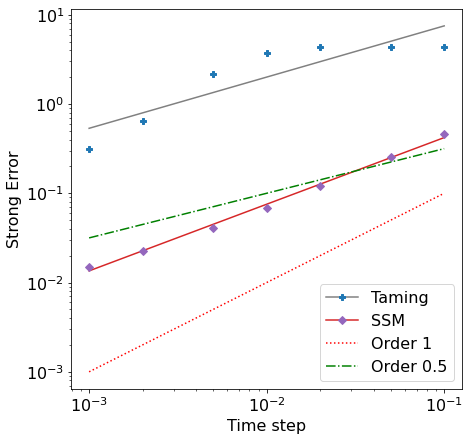

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
plt.rcParams['font.size'] = '16'
plt.rcParams["figure.figsize"] = (7,7)


plt.xlabel('Time step')  
plt.ylabel('Strong Error') 

#plt.title('Different method compare to the exact solution')

#plt.xlim(0,0.1)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log') 
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(timestep),np.log(strong_error_taming1),1)
a,=plt.plot(timestep, (timestep**m1)*np.exp(b1),color='grey' )
b,=plt.plot(timestep,strong_error_taming1,'P',color='C0')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_taming2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_taming2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_split_step1),1)
j,=plt.plot(timestep, (timestep**m2)*np.exp(b2),color='C3' )
k,=plt.plot(timestep,strong_error_split_step1,'D',color='C4')



#g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
z,=plt.plot(timestep, (timestep**1),':',label='Order 1',color='red')
z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(j,k),z,z2],['Taming',r'SSM','Order 1','Order 0.5'])
plt.savefig('FIG-0531-vdp-se.png', dpi=100)

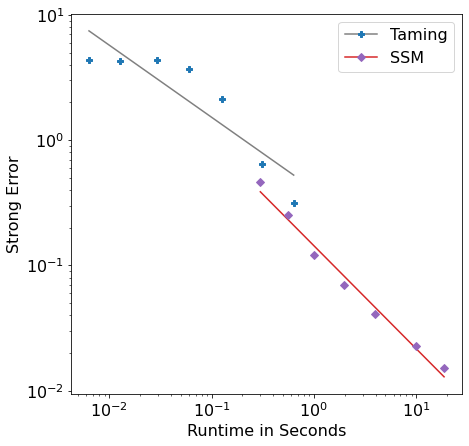

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=[0.1,0.2,0.5,1,2,5,10,20,50,100,200]

plt.rcParams["figure.figsize"] = (7,7)


plt.xlabel('Runtime in Seconds')  
plt.ylabel('Strong Error') 

#plt.title('Different method compare to the exact solution')

#plt.xlim(0,0.1)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log') 
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(time_tam),np.log(strong_error_taming1),1)
a,=plt.plot(time_tam, (time_tam**m1)*np.exp(b1),color='grey' )
b,=plt.plot(time_tam,strong_error_taming1,'P',color='C0')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_taming2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_taming2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m2, b2 = np.polyfit(np.log(time_ssm),np.log(strong_error_split_step1),1)
j,=plt.plot(time_ssm, (time_ssm**m2)*np.exp(b2),color='C3' )
k,=plt.plot(time_ssm,strong_error_split_step1,'D',color='C4')


# #g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
# z,=plt.plot(timestep, (timestep**1),':',label='Order 1',color='red')
# z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(j,k)],['Taming',r'SSM'])
plt.savefig('FIG-0531-vdp-time.png', dpi=100)

## Phase graphs

### N(0,1) N(-2,1)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    time_end=round(ii*h,round_scheme)
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000


In [ ]:
particle_split_step_exact1

tensor([[[-0.34383760,  0.35519321],
         [-1.31887115, -0.97013682],
         [ 0.42751803, -0.39275778],
         ...,
         [-0.11736660, -1.14696050],
         [ 1.30123362, -1.22350130],
         [ 0.68563541, -2.19849686]],

        [[ 1.12022716, -1.26062353],
         [ 0.51929732, -0.49254369],
         [ 2.16778210, -0.53697243],
         ...,
         [ 1.97279602, -1.00252573],
         [ 2.42374436, -0.31235867],
         [ 1.36221820, -0.32112001]]], dtype=torch.float64)

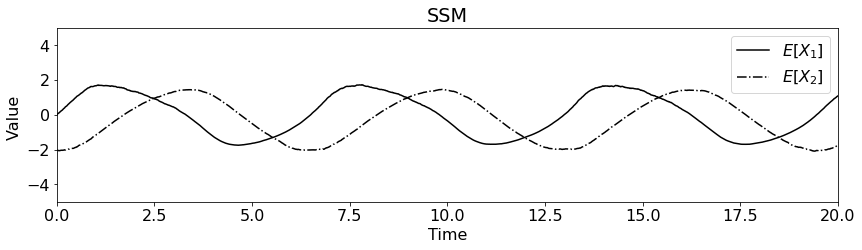

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
plt.savefig('x3-220406-vdp-e1-ssm.png', dpi=100)

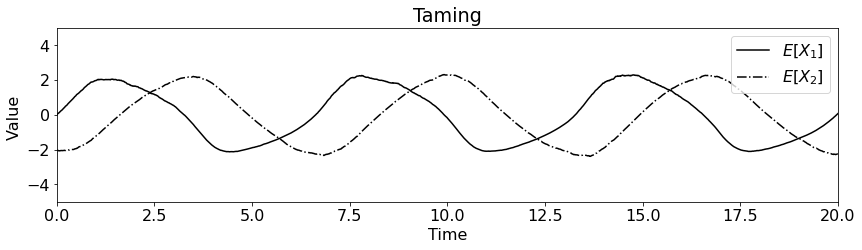

In [ ]:
### Convert to cpu and numpy
T=20
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
plt.savefig('x3-220406-vdp-e1-tam1.png', dpi=100)

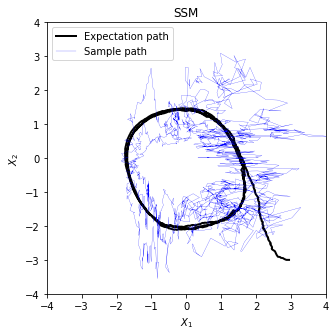

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[0,:,0], path_ssm_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p1-ssm.png', dpi=100)

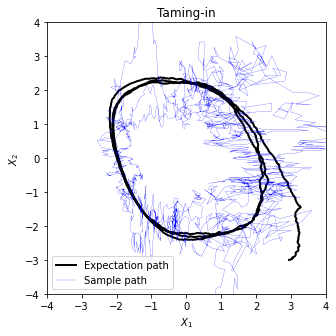

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming-in')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[0,:,0], path_tam_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p1-tam1.png', dpi=100)

### N(2,6) N(0,6)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(3,4)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-3,4)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    time_end=round(ii*h,round_scheme)
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000


In [ ]:
particle_taming_exact2[1]

tensor([[-0.88409362, -1.40664216],
        [-0.37127183, -1.44725287],
        [-0.25585077, -1.51103816],
        ...,
        [ 0.38000894, -1.30773256],
        [ 0.26081494, -1.12131947],
        [ 0.06443490, -1.31733953]], dtype=torch.float64)

In [ ]:
particle_taming_exact1[1,100:110],particle_taming_exact1[0,100:110],

In [ ]:
particle_taming_exact1[1,100:110],particle_taming_exact1[0,100:110],

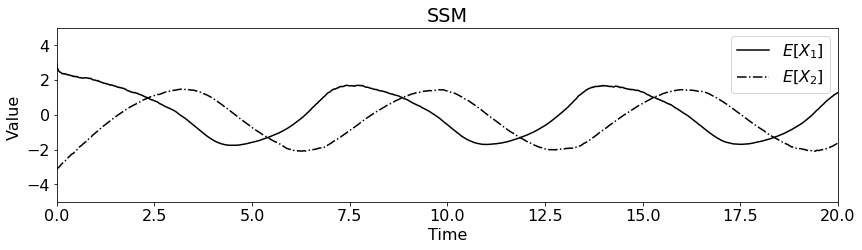

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ,loc='upper right') 
plt.savefig('x3-220406-vdp-e2-ssm.png', dpi=100)

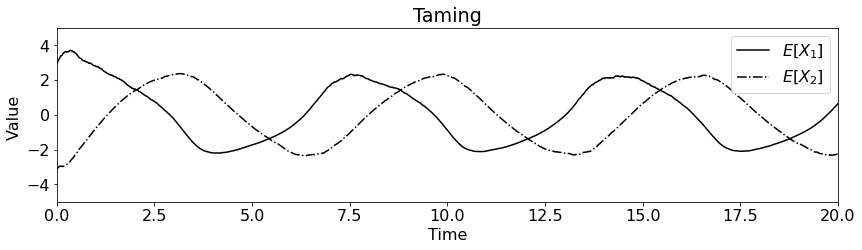

In [ ]:
### Convert to cpu and numpy
T=20
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ,loc='upper right') 
plt.savefig('x3-220406-vdp-e2-tam1.png', dpi=100)

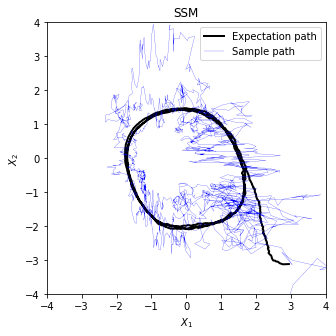

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[3,:,0], path_ssm_sample_cpu[3,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p2-ssm.png', dpi=100)

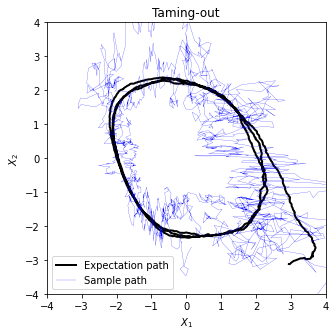

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming-out')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[3,:,0], path_tam_sample_cpu[3,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p2-tam1.png', dpi=100)

In [ ]:
path_tam_sample_cpu[0,:10,0],path_tam_sample_cpu[0,:10,1]

(array([5.12427098, 5.43822393, 5.10725694, 5.13508706, 5.02420507,
        4.63565401, 4.13959199, 4.21563146, 4.30705516, 4.23325736]),
 array([8.28457901, 8.16329554, 8.04274978, 7.92276603, 7.80351074,
        7.68496976, 7.5670999 , 7.44996063, 7.33373017, 7.21847345]))

In [ ]:
path_tam2_sample_cpu[0,:10,0],path_tam2_sample_cpu[0,:10,1]

(array([5.12427098, 5.44524874, 5.10758701, 5.13924734, 5.02928688,
        4.64295041, 4.15723698, 4.2547138 , 4.36521522, 4.304434  ]),
 array([8.28457901, 8.18505276, 8.08595321, 7.98768565, 7.88999829,
        7.793066  , 7.69707803, 7.60202441, 7.50762235, 7.4139024 ]))

In [ ]:
path_ssm_sample_cpu[0,:10,0],path_ssm_sample_cpu[0,:10,1]

(array([5.12427098, 5.14216767, 4.63484822, 4.50551189, 4.29888642,
        3.91912714, 3.4978408 , 3.53003302, 3.57597856, 3.50228973]),
 array([8.28457901, 7.42344806, 6.75516818, 6.23196082, 5.80533741,
        5.4501379 , 5.15259181, 4.90029024, 4.6782925 , 4.48095165]))

In [ ]:
path_tam2_sample_cpu[1,:10,0],path_tam2_sample_cpu[1,:10,1]

(array([1.21265405, 1.20648986, 1.21453052, 1.16423903, 1.19157923,
        1.27224067, 1.23819992, 1.24231048, 1.22169863, 1.19994297]),
 array([6.75985905, 6.67224988, 6.58551125, 6.49964471, 6.41457321,
        6.33045069, 6.24742489, 6.16525291, 6.0840104 , 6.00369715]))

In [ ]:
path_ssm_sample_cpu[3,:10,0],path_ssm_sample_cpu[3,:10,1]

(array([0.05362507, 0.23720515, 0.31909775, 0.41614871, 0.46461944,
        0.56220236, 0.59497314, 0.62221176, 0.63309389, 0.59608137]),
 array([-3.39775876, -3.18926402, -3.01978076, -2.87747114, -2.75653067,
        -2.65132848, -2.55882297, -2.47616037, -2.40162444, -2.33393216]))

In [ ]:
path_tam2_sample_cpu[3,:10,0],path_tam2_sample_cpu[3,:10,1]

(array([0.05362507, 0.15060463, 0.17163298, 0.22120453, 0.23659756,
        0.30692173, 0.32237352, 0.33696121, 0.33951056, 0.3004982 ]),
 array([-3.39775876, -3.34866321, -3.30024276, -3.25244342, -3.20535928,
        -3.15894642, -3.11324124, -3.06818872, -3.02384784, -2.98016494]))

In [ ]:
aaa=1
path_ssm_sample_cpu[aaa,:10,0],path_ssm_sample_cpu[aaa,:10,1],path_tam2_sample_cpu[aaa,:10,0],path_tam2_sample_cpu[aaa,:10,1],path_tam_sample_cpu[aaa,:10,0],path_tam_sample_cpu[aaa,:10,1],

(array([1.21265405, 1.25180926, 1.29478693, 1.2679591 , 1.31876226,
        1.42065126, 1.39379576, 1.40680949, 1.39124054, 1.37320836]),
 array([6.75985905, 6.19140718, 5.74111131, 5.37380604, 5.06837476,
        4.80848198, 4.58410275, 4.38781372, 4.21417666, 4.05925704]),
 array([1.21265405, 1.20648986, 1.21453052, 1.16423903, 1.19157923,
        1.27224067, 1.23819992, 1.24231048, 1.22169863, 1.19994297]),
 array([6.75985905, 6.67224988, 6.58551125, 6.49964471, 6.41457321,
        6.33045069, 6.24742489, 6.16525291, 6.0840104 , 6.00369715]),
 array([1.21265405, 1.24649643, 1.29434344, 1.28202405, 1.34849544,
        1.46833905, 1.46451588, 1.49992515, 1.50575064, 1.50617187]),
 array([6.75985905, 6.6421032 , 6.52542105, 6.40989429, 6.29556324,
        6.1825585 , 6.07092047, 5.9606866 , 5.85187525, 5.74458315]))

In [ ]:
aaa=2
path_ssm_sample_cpu[aaa,:10,0],path_ssm_sample_cpu[aaa,:10,1],path_tam2_sample_cpu[aaa,:10,0],path_tam2_sample_cpu[aaa,:10,1],path_tam_sample_cpu[aaa,:10,0],path_tam_sample_cpu[aaa,:10,1],

(array([2.33687359, 2.25484248, 2.2937495 , 2.24860839, 2.21961043,
        2.22521247, 2.12336541, 2.09295673, 2.00679215, 1.87542009]),
 array([7.17141258, 6.54362816, 6.04931774, 5.64782307, 5.31557285,
        5.03367749, 4.79066658, 4.57895512, 4.39216794, 4.22604867]),
 array([2.33687359, 0.11446134, 0.14899444, 0.14566344, 0.14743695,
        0.16378071, 0.13051934, 0.12688399, 0.09529143, 0.03783838]),
 array([ 7.17141258, -1.88118017, -1.881302  , -1.88138607, -1.88147826,
        -1.881564  , -1.88162992, -1.88172967, -1.88183006, -1.88196204]),
 array([2.33687359, 2.25902916, 2.30141583, 2.26077248, 2.23472726,
        2.24228327, 2.14680581, 2.12455861, 2.04638985, 1.92131705]),
 array([7.17141258, 7.05282984, 6.9351128 , 6.81842598, 6.7027928 ,
        6.58825553, 6.47483139, 6.36259056, 6.25157926, 6.14186286]))

The first step of the Taming v.2 is quiet wired, it suddenly break something, and then start to move normally
 

In [ ]:
path_ssm_sample_cpu[0,:,0]

array([-0.09546834, -0.09049836, -0.04489472, ...,  1.19975604,
        1.22015245,  1.19728678])

In [ ]:
path_tam_sample_cpu[0,:,0]

array([-0.09546834, -0.09048797, -0.04497465, ...,  1.22162712,
        1.24214993,  1.2191479 ])

In [ ]:
path_ssm=torch.randn(100,2, dtype=torch.float64)

In [ ]:
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()

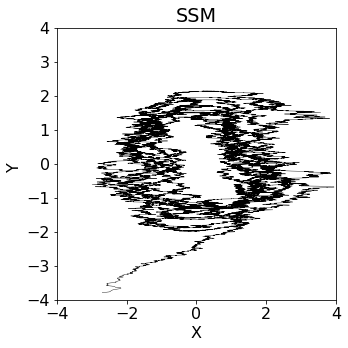

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[0,:,0], path_ssm_sample_cpu[0,:,1],color='black', linewidth=0.4)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

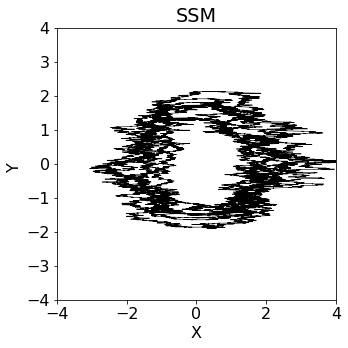

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[1,:,0], path_ssm_sample_cpu[1,:,1],color='black',linewidth=0.6)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

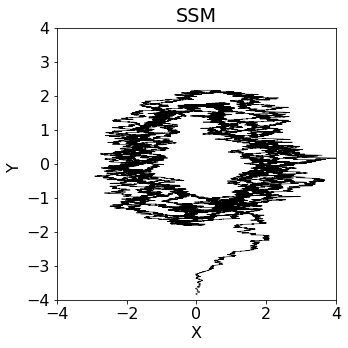

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[3,:,0], path_ssm_sample_cpu[3,:,1],color='black',linewidth=0.6)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

In [ ]:
a[:,1,:]

tensor([[ 0.69091289, -0.14337401],
        [ 0.28328026, -2.76063330],
        [-0.01396274, -1.21353213],
        [ 0.95413151, -1.54565877],
        [ 0.84787965, -1.84951934],
        [-0.34777950, -1.38346042],
        [ 0.30334550, -0.59684666],
        [-1.95773862, -0.50942256],
        [ 0.45640616, -0.02431654],
        [ 1.41002732, -4.05298716]], dtype=torch.float64)

In [ ]:
particle_split_step_exact1[1][:10]

tensor([[ 0.40454488, -0.83227914],
        [-0.22313729, -2.41626340],
        [-0.61556862, -0.19337399],
        [-0.90924098, -1.82521675],
        [-1.82353292, -1.99704146],
        [ 0.11064349, -1.72490523],
        [-0.69405520, -0.61186932],
        [ 0.08205527, -0.90854439],
        [ 1.48746884, -3.44912419],
        [ 0.15037643, -1.52661568]], dtype=torch.float64)

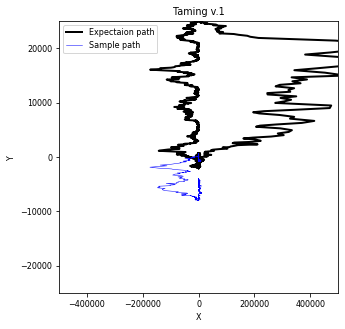

In [ ]:
### Plotting part T=40
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '8'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('Taming v.1')

plt.xlim(-500000, 500000)
plt.ylim(-25000, 25000)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[1,:,0], path_tam_sample_cpu[1,:,1],color='blue', linewidth=0.5)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectaion path',r'Sample path'] ) 
plt.savefig('220403-vdpa-p2-tam2v1.png', dpi=100)

# Version 2 $\mu$=4


Van der Pol oscillator
\begin{equation}
f(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
-x\left(x^{2}+y^{2}\right) \\
-y\left(x^{2}+y^{2}\right)
\end{array}\right]
\qquad
\partial f(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
-3x^{2}& -y^2 \\
 -x^2&-3y^{2}
\end{array}\right]
\end{equation}

Basic: 
 \begin{align}
d X_{t} &= \Big( v(X_{t},\mu_{t}^{X}) + b(t,X_{t}, \mu_{t}^{X})\Big)d t + \sigma(t,X_{t}, \mu_{t}^{X})d W_{t},  \quad X_{0} \in L_{0}^{m}( R^{d}),\\
v(x,\mu)&= u(x,\mu)+ \int_{R^{d}  } f(x-y) \mu(dy) 
,\qquad 
u(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
-\frac43 x^3 \\
0
\end{array}\right]
,
\qquad 
b(\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
4x-4y \\
-\frac14 x
\end{array}\right]
,
\qquad
\sigma (\left[\begin{array}{l}
x \\
y
\end{array}\right])=
\left[\begin{array}{l}
1+ x \\
y
\end{array}\right]
\end{align}

## Method

In [ ]:
def torch_make_brownian_motion(bm,h):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm), dtype=torch.float64, device='cuda')
    return(0)

def torch_make_brownian_motion_md(bm,h,d):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm),d, dtype=torch.float64, device='cuda')
    return(0)


def f3(a): #a: N x N x 2
    nn=len(a)
    result=(torch.sum(a**2,2).reshape(nn,nn,1))*a
    return(-torch.mean(result,1))
#     return(result)
    


def f3_tam(a,mma): #a: N x N x 2
    nn=len(a)
    result=(torch.sum(a**2,2).reshape(nn,nn,1))*a
    result=result/(1+mma*torch.abs(result))

    return(-torch.mean(result,1))

    

def df3(aa):
    nn=len(aa)
    dd=len(aa[0,0])
    df=torch.matmul(aa.reshape(nn,nn,dd,1),aa.reshape(nn,nn,1,dd))*(-2)
    _norm2=-torch.sum(aa**2,2).reshape(nn,nn,1)
    df+=_norm2.reshape(nn,nn,1,1)*torch.eye(dd)
    
    return(torch.mean(df,1))

def du3(aa):
    nn=len(aa)
    ddd=len(aa[0])
    df=torch.zeros((nn,ddd,ddd), dtype=torch.float64, device='cuda')   
    df[:,0,0]=-aa[:,0]**2
    return(df)


def sigma3(aa):
    sig=aa.detach().clone()
    return(sig)

def b3(aa):
    bb=aa.detach().clone()    
    return(bb)



def torch_ssm_method(x,bm,h,T,N):  #x : 2xNx2
    mu=4.0
    # N=len(x[0])
    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    mul_1=torch.tensor([1,-1])
    ddd=len(x[1,0])
    mul_2=torch.eye(ddd, dtype=torch.float64,  device='cuda')
    dd=len(x[1,0])
    
    bb_matrix=torch.tensor([[mu,-mu],[1/mu,0.]], dtype=torch.float64,  device='cuda'  )
    sig_matrix=torch.tensor([1.,0.] ,  dtype=torch.float64, device='cuda' )
    sig_y=torch.tensor([1.,1.] ,  dtype=torch.float64, device='cuda' )
    
    pd=True
    while pd:
        sample_vre = torch.reshape(y[1,:N],(N,1,dd))
        
        nominator_tmp = sample_vre-y[1,:N]
#         nom_tmp =  -nominator_tmp**3 
        
        vy =  f3(nominator_tmp)      
        
        uy = y.detach().clone()
        uy[1,:N,1]=0
        
        # FF=(vy*h-h*uy[1,:N]**3-y[1,:N]+x[1,:N])
        
        FF=(vy*h-(mu*h/3*uy[1,:N]**3)-y[1,:N]+x[1,:N])
        
        d_f=df3(nominator_tmp)
        
        # d_uy= du3( uy[1,:N])
        # d_FF=h*(d_f+d_uy)-mul_2

        
        d_FF=h*(d_f)-mul_2
        d_FF[:,0,0]+=-mu*uy[1,:N,0]**2*h

        inv_d_FF=torch.linalg.inv(d_FF)
        FF=FF.reshape(N,dd,1)
        
        inv_d_FF_x_FF=torch.matmul(inv_d_FF,FF)
        
        y[1,:N]+= -inv_d_FF_x_FF.reshape(N,dd)
        
        if torch.max(torch.abs(inv_d_FF_x_FF))<=sqrth:  
            pd=False
            #print( max(np.abs(fovergprime)) )
    
     
    
    dWt=bm[:N]-x[0,:N]
    x[0,:N]=bm[:N]
#     x[1,:N]=y[1,:N]+bb*h + sigg*dWt
    x[1,:N]=y[1,:N]+(torch.matmul(bb_matrix,y[1,:N].reshape(N,2,1))*h).reshape(N,2)+(sig_matrix+(sig_y*y[1,:N]))*dWt
    return(0)



def torch_taming_method(x,bm,h,T,N):  #x : 2xNx2
    mu=4.0
    # N=len(x[0])
    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    mul_1=torch.tensor([1,-1])
    mul_2=torch.tensor([[1,0],[0,1]])
    mma=M**(-alpha)
    bb_matrix=torch.tensor([[mu,-mu],[1/mu,0.]], dtype=torch.float64,  device='cuda'  )
    sig_matrix=torch.tensor([1.,0.] ,  dtype=torch.float64, device='cuda' )
    sig_y=torch.tensor([1.,1.] ,  dtype=torch.float64, device='cuda' )
    
    sample_vre = torch.reshape(x[1,:N],(N,1,2))    
    nominator_tmp = sample_vre-x[1,:N]
    vx =  f3(nominator_tmp)
    
    
    vx[:,0]+=-mu*x[1,:N,0]**3/3
    

    
    dWt=bm[:N]-x[0,:N]
    x[0,:N]=bm[:N]
    sigx=(sig_matrix+(sig_y*x[1,:N]))
    x[1,:N]+=h*vx/(1+mma*torch.abs(vx))+(torch.matmul(bb_matrix,x[1,:N].reshape(N,2,1))*h).reshape(N,2)+(sigx)*dWt
    return(0)





In [ ]:
def torch_calculation_weak_error(exact,approx):
    n=len(exact[1])
    ex=torch.reshape(exact[1,:],(1,2*N))
    ap=torch.reshape(approx[1,:],(1,2*N))
    weak_error=abs(ex-ap)
    torch.mean(weak_error)
    return(torch.mean(weak_error).tolist())

def torch_calculation_strong_error(exact,approx):
    n=len(exact[1])
    ex=torch.reshape(exact[1,:],(1,2*N))
    ap=torch.reshape(approx[1,:],(1,2*N))
    strong_error=(ex-ap)**2
    return(np.sqrt(torch.mean(strong_error).tolist()))

def calculation_path_error(prev,exact,approx):
    N=len(exact)
    ex=torch.reshape(exact,(1,2*N))
    ap=torch.reshape(approx,(1,2*N))
    aaaa=(ex-ap)**2
    prev=torch.max( prev,aaaa)
    return( prev)

## Strong error w.r.t $h$

In [ ]:
T=1
d=2
M=int(1e4)
h=1e-4
n_of_scheme=8
n=1000
N=n
round_scheme=10



timestep=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
moder=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
for i in range(len(moder)):
    moder[i]=int(moder[i]*(1e4))

nmoder=len(moder)



#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

time_ssm=np.zeros(nmoder)
time_tam=np.zeros(nmoder)

particle_taming_method1=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_taming_method2=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_split_step_method1=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_split_step_method2=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_euler_method=torch.zeros(nmoder,2,N,2, dtype=torch.float64)

path_diff_ssm=torch.zeros(nmoder,2*N, dtype=torch.float32,  device='cuda')
path_diff_tam=torch.zeros(nmoder,2*N, dtype=torch.float32,  device='cuda')


#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000

    for j in range(nmoder):
        particle_taming_method1[j][1][i][0]=xxx000
        particle_taming_method2[j][1][i][0]=xxx000
        particle_split_step_method1[j][1][i][0]=xxx000
        particle_euler_method[j][1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
    for j in range(nmoder):
        particle_taming_method1[j][1][i][1]=xxx000
        particle_split_step_method1[j][1][i][1]=xxx000
        particle_euler_method[j][1][i][1]=xxx000

xxx=0
M=int(T/h)

for ii in range(1,M+1):
# for ii in range(1,100+1):
    time_end=round(ii*h,round_scheme)
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)
    for j in range(len(moder)):
        if (ii%moder[j]==0):
            t1=time.time()
            torch_taming_method(particle_taming_method1[j],bm,timestep[j],T,N)
            t2=time.time()
            torch_ssm_method(particle_split_step_method1[j],bm,timestep[j],T,N)
            t3=time.time()
            time_ssm[j]+=t3-t2
            time_tam[j]+=t2-t1

            path_diff_ssm[j]=calculation_path_error(path_diff_ssm[j], particle_split_step_exact1[1] ,particle_split_step_method1[j][1] )
            path_diff_tam[j]=calculation_path_error(path_diff_tam[j], particle_taming_exact1[1] ,particle_taming_method1[j][1] )




1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [ ]:
particle_split_step_exact1[1].shape,path_diff_ssm.shape

(torch.Size([1000, 2]), torch.Size([7, 2000]))

In [ ]:
calculation_path_error(path_diff_ssm[j], particle_split_step_exact1[1] ,particle_split_step_method1[j][1] ).shape

torch.Size([1, 2000])

In [ ]:
time_ssm,time_tam

(array([19.32372904,  9.68706083,  3.89193892,  2.06637883,  1.44476151,
         0.65560985,  0.40562439]),
 array([0.58065939, 0.28876901, 0.11578417, 0.05749869, 0.0294435 ,
        0.01137328, 0.00610137]))

In [ ]:
particle_taming_exact1[1]

tensor([[ 1.37669473, -0.91703659],
        [ 3.97869872, -1.99567063],
        [ 1.56323264, -0.71784686],
        ...,
        [ 1.31381694, -1.30438584],
        [ 1.97779535, -1.01092512],
        [ 2.99045737, -1.88025418]], dtype=torch.float64)

In [ ]:
particle_split_step_exact1[1]

tensor([[ 1.23576921, -0.88127577],
        [ 3.41833904, -1.96421249],
        [ 1.33946812, -0.67840943],
        ...,
        [ 1.09756120, -1.23594889],
        [ 1.76366876, -0.98884319],
        [ 2.62623980, -1.84773487]], dtype=torch.float64)

### Calculation of errors and plots

In [ ]:
 ## calculation of the errors
strong_error_taming1=[0 for i in range(nmoder)]
strong_error_taming2=[0 for i in range(nmoder)]
strong_error_split_step1=[0 for i in range(nmoder)]
#strong_error_split_step2=[0 for i in range(nmoder)]
# strong_error_adaptive=[0 for i in range(nmoder)]
#strong_error_euler=[0 for i in range(nmoder)]
for i in range(nmoder):
    strong_error_taming1[i]=torch_calculation_strong_error(particle_taming_exact1,particle_taming_method1[i])
    strong_error_taming2[i]=torch_calculation_strong_error(particle_taming_exact2,particle_taming_method2[i])
    strong_error_split_step1[i]=torch_calculation_strong_error(particle_split_step_exact1,particle_split_step_method1[i])
    # strong_error_adaptive[i]=calculation_strong_error(particle_adaptive_timestep_method[0],particle_adaptive_timestep_method[i+1])
    #strong_error_split_step2[i]=calculation_strong_error(particle_split_step_exact2,particle_split_step_method2[i])
    #strong_error_euler[i]=calculation_strong_error(particle_euler_exact,particle_euler_method[i])
    #strong_error_splitting[i]=calculation_strong_error(particle_splitting_exact,particle_splitting_method[i])

weak_error_taming1=[0 for i in range(nmoder)]
weak_error_taming2=[0 for i in range(nmoder)]
weak_error_split_step1=[0 for i in range(nmoder)]
#weak_error_split_step2=[0 for i in range(nmoder)]
# weak_error_adaptive=[0 for i in range(nmoder)]
#weak_error_euler=[0 for i in range(nmoder)]

for i in range(nmoder):
    weak_error_taming1[i]=torch_calculation_weak_error(particle_taming_exact1,particle_taming_method1[i])
    weak_error_taming2[i]=torch_calculation_weak_error(particle_taming_exact2,particle_taming_method2[i])
    weak_error_split_step1[i]=torch_calculation_weak_error(particle_split_step_exact1,particle_split_step_method1[i])
    # weak_error_adaptive[i]=calculation_weak_error(particle_adaptive_timestep_method[0],particle_adaptive_timestep_method[i+1])
    #weak_error_split_step2[i]=calculation_weak_error(particle_split_step_exact2,particle_split_step_method2[i])
    #weak_error_euler[i]=calculation_weak_error(particle_euler_exact,particle_euler_method[i])

In [ ]:
strong_error_split_step1,strong_error_taming1,strong_error_taming2

([0.018553442632999434,
  0.03334349927701312,
  0.07770914318004726,
  0.15101649838094391,
  0.2890609303916589,
  0.720405592444931,
  1.3986749468676867],
 [37.34095673440369,
  74.07869299855788,
  106.74805340701832,
  116.99800552461106,
  115.29472879995716,
  96.91534110844597,
  72.3133100309267],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
strong_error_split_step1,strong_error_taming1,strong_error_taming2

([0.0150868751551189,
  0.02277167523589102,
  0.04118869740734533,
  0.06915424316918688,
  0.12042921986050868,
  0.2546974093713864,
  0.46065346848740746],
 [0.3141707867004211,
  0.6394448744221464,
  2.141134521252369,
  3.6944612614516634,
  4.3287397514447035,
  4.322262955331754,
  4.336118279597332],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
weak_error_split_step1,weak_error_taming1,weak_error_taming2

([0.011285018526907779,
  0.016883599260267116,
  0.03039588227878483,
  0.04953780464003178,
  0.08496025438681565,
  0.1765859518549398,
  0.32314004473452496],
 [0.2435315394923459,
  0.48999503704131847,
  1.427945382620405,
  2.640190519899826,
  3.1926024359536442,
  2.90845615136575,
  2.610770570957594],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

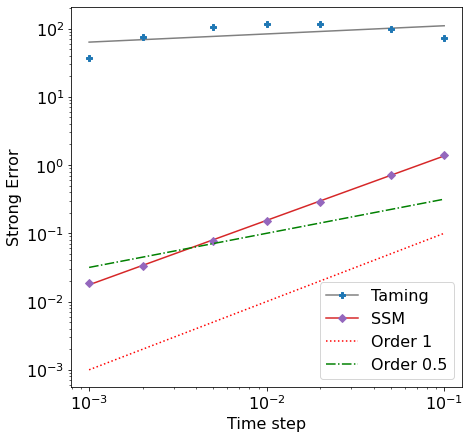

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
plt.rcParams['font.size'] = '16'
plt.rcParams["figure.figsize"] = (7,7)


plt.xlabel('Time step')  
plt.ylabel('Strong Error') 

#plt.title('Different method compare to the exact solution')

#plt.xlim(0,0.1)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log') 
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(timestep),np.log(strong_error_taming1),1)
a,=plt.plot(timestep, (timestep**m1)*np.exp(b1),color='grey' )
b,=plt.plot(timestep,strong_error_taming1,'P',color='C0')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_taming2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_taming2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_split_step1),1)
j,=plt.plot(timestep, (timestep**m2)*np.exp(b2),color='C3' )
k,=plt.plot(timestep,strong_error_split_step1,'D',color='C4')



#g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
z,=plt.plot(timestep, (timestep**1),':',label='Order 1',color='red')
z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(j,k),z,z2],['Taming',r'SSM','Order 1','Order 0.5'])
plt.savefig('FIG-0531-vdp-se.png', dpi=100)

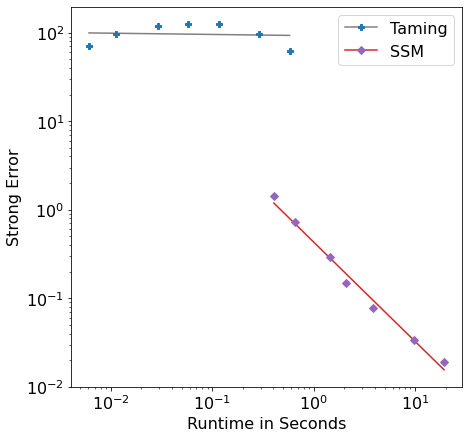

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=[0.1,0.2,0.5,1,2,5,10,20,50,100,200]

plt.rcParams["figure.figsize"] = (7,7)


plt.xlabel('Runtime in Seconds')  
plt.ylabel('Strong Error') 

#plt.title('Different method compare to the exact solution')

#plt.xlim(0,0.1)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log') 
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(time_tam),np.log(strong_error_taming1),1)
a,=plt.plot(time_tam, (time_tam**m1)*np.exp(b1),color='grey' )
b,=plt.plot(time_tam,strong_error_taming1,'P',color='C0')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_taming2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_taming2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m2, b2 = np.polyfit(np.log(time_ssm),np.log(strong_error_split_step1),1)
j,=plt.plot(time_ssm, (time_ssm**m2)*np.exp(b2),color='C3' )
k,=plt.plot(time_ssm,strong_error_split_step1,'D',color='C4')


# #g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
# z,=plt.plot(timestep, (timestep**1),':',label='Order 1',color='red')
# z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(j,k)],['Taming',r'SSM'])
plt.savefig('FIG-0531-vdp-time.png', dpi=100)

In [ ]:
 ## calculation of the path errors
strong_error_taming1=np.zeros( (nmoder) )
strong_error_taming2=np.zeros( (nmoder) )
strong_error_split_step1=np.zeros( nmoder )

for i in range(nmoder):
    strong_error_taming1[i]= np.sqrt(torch.mean(path_diff_tam[i]).item())
 
    strong_error_split_step1[i]=np.sqrt(torch.mean(path_diff_ssm[i]).item())

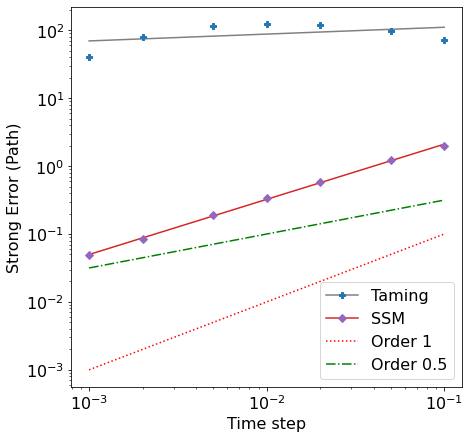

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]
plt.rcParams['font.size'] = '16'
plt.rcParams["figure.figsize"] = (7,7)


plt.xlabel('Time step')  
plt.ylabel('Strong Error (Path)') 

#plt.title('Different method compare to the exact solution')

#plt.xlim(0,0.1)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log') 
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(timestep),np.log(strong_error_taming1),1)
a,=plt.plot(timestep, (timestep**m1)*np.exp(b1),color='grey' )
b,=plt.plot(timestep,strong_error_taming1,'P',color='C0')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_taming2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_taming2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_split_step1),1)
j,=plt.plot(timestep, (timestep**m2)*np.exp(b2),color='C3' )
k,=plt.plot(timestep,strong_error_split_step1,'D',color='C4')



#g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
z,=plt.plot(timestep, (timestep**1),':',label='Order 1',color='red')
z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(j,k),z,z2],['Taming',r'SSM','Order 1','Order 0.5'])
plt.savefig('FIG-0531-vdp-se.png', dpi=100)

## Strong error w.r.t $N$

In [ ]:
T=1
d=2
M=int(1e4)
h=1e-3



n_of_scheme=[40,80,160,320,640,1280]
nmoder=len(n_of_scheme)
N=2560
n=N


#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

time_ssm=np.zeros(nmoder)
time_tam=np.zeros(nmoder)

particle_taming_method1=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_taming_method2=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_split_step_method1=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_split_step_method2=torch.zeros(nmoder,2,N,2, dtype=torch.float64)
particle_euler_method=torch.zeros(nmoder,2,N,2, dtype=torch.float64)

#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000

    for j in range(nmoder):
        particle_taming_method1[j][1][i][0]=xxx000
        particle_taming_method2[j][1][i][0]=xxx000
        particle_split_step_method1[j][1][i][0]=xxx000
        particle_euler_method[j][1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
    for j in range(nmoder):
        particle_taming_method1[j][1][i][1]=xxx000
        particle_split_step_method1[j][1][i][1]=xxx000
        particle_euler_method[j][1][i][1]=xxx000

xxx=0
M=int(T/h)

for ii in range(1,M+1):
# for ii in range(1,100+1):

    if ii%100==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)
    for j in range(nmoder):
        t1=time.time()
        torch_taming_method(particle_taming_method1[j],bm,h,T,n_of_scheme[j] )
        t2=time.time()
        torch_ssm_method(particle_split_step_method1[j],bm,h,T,n_of_scheme[j])
        t3=time.time()
        time_ssm[j]+=t3-t2
        time_tam[j]+=t2-t1

100
200
300
400
500
600
700
800
900
1000


In [ ]:
time_ssm,time_tam

(array([ 2.26702404,  2.30455017,  2.38633847,  3.82410622,  9.53953266,
        31.69441628]),
 array([0.78945494, 0.67649889, 0.6921308 , 0.71021485, 0.71586204,
        0.67918038]))

In [ ]:
particle_taming_exact1[1]

tensor([[ 70.01202051,  10.41162832],
        [100.67765105,   7.19386763],
        [128.51435297,   7.40821514],
        ...,
        [ 42.15657858,   8.91719785],
        [ 25.60387161,   9.05553088],
        [ 19.00178872,   5.66254231]], dtype=torch.float64)

In [ ]:
particle_split_step_exact1[1]

tensor([[ 2.27016379, -1.21370677],
        [ 2.22302961, -2.26815002],
        [ 2.72286885, -1.03191388],
        ...,
        [ 1.51161604, -1.46267749],
        [ 1.25942394, -1.69260451],
        [ 1.95645341, -1.45157838]], dtype=torch.float64)

### Calculation of errors and plots

In [ ]:
meanlist=[]
for j in (range(len(n_of_scheme))):
    nn=n_of_scheme[j]
    a1=torch.mean( (particle_taming_method1[j][1][:nn].reshape(d*nn,1)-particle_taming_exact1[1][:nn].reshape(d*nn,1))**2 )
    a1=torch.sqrt(a1)  
    a3=torch.mean( (particle_split_step_method1[j][1][:nn].reshape(d*nn,1)-particle_split_step_exact1[1][:nn].reshape(d*nn,1))**2 )
    a3=torch.sqrt(a3)
    meanlist.append([a1,a3])

strong_error_split_step1=[]
strong_error_taming1=[]

for i in range(len(meanlist)):
  strong_error_taming1.append(meanlist[i][0].item())
  strong_error_split_step1.append(meanlist[i][1].item())

In [ ]:
strong_error_split_step1,strong_error_taming1

([0.45796301850573223,
  0.2550409163988267,
  0.2807740212000087,
  0.25682978927953043,
  0.06813145803692651,
  0.019879172587932092],
 [42.32055223486024,
  40.5922445274946,
  36.27889545873803,
  24.77965766666451,
  19.36093764158565,
  8.387083351108279])

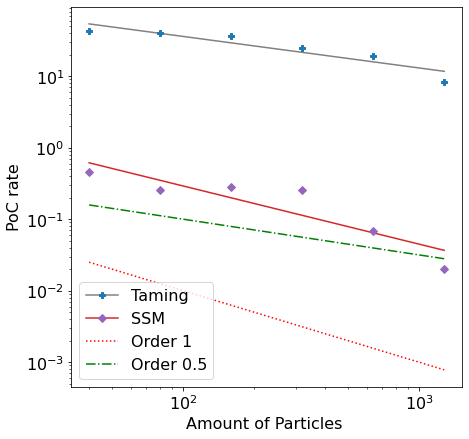

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=n_of_scheme
plt.rcParams['font.size'] = '16'
plt.rcParams["figure.figsize"] = (7,7)


plt.xlabel('Amount of Particles ')  
plt.ylabel('PoC rate') 

#plt.title('Different method compare to the exact solution')

#plt.xlim(0,0.1)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log') 
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(timestep),np.log(strong_error_taming1),1)
a,=plt.plot(timestep, (timestep**m1)*np.exp(b1),color='grey' )
b,=plt.plot(timestep,strong_error_taming1,'P',color='C0')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_taming2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_taming2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_split_step1),1)
j,=plt.plot(timestep, (timestep**m2)*np.exp(b2),color='C3' )
k,=plt.plot(timestep,strong_error_split_step1,'D',color='C4')



#g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
z,=plt.plot(timestep, (1/timestep),':',label='Order 1',color='red')
z2,=plt.plot(timestep, (timestep**(-0.5)),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(j,k),z,z2],['Taming',r'SSM','Order 1','Order 0.5'])
plt.savefig('FIG-0531-vdp-poc.png', dpi=100)

## Phase graphs

### N(0,1) N(-2,1)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000


In [ ]:
particle_split_step_exact1

tensor([[[  9.43485531,  -4.38620383],
         [-10.16543128,  -1.45493599],
         [ -4.00352088,  -1.29496385],
         ...,
         [ -6.05767587,  -0.45546998],
         [ -3.27196966,  -1.10589262],
         [  2.02864408,  -4.87930606]],

        [[  2.06760785,  -0.27238210],
         [  0.98728483,  -0.57952555],
         [  2.12608697,  -1.04264784],
         ...,
         [  1.03453363,  -0.13952421],
         [  1.98781250,  -0.46254874],
         [  1.95850887,  -0.51591219]]], dtype=torch.float64)

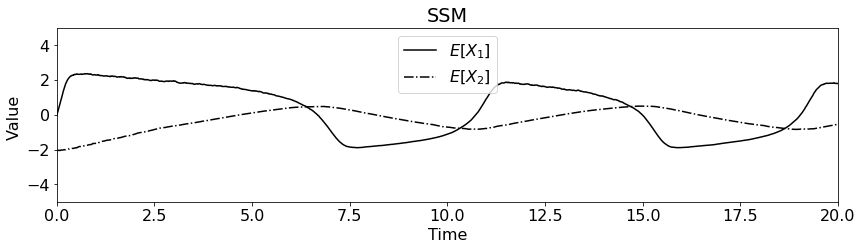

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
# plt.savefig('x3-220406-vdp-e1-ssm.png', dpi=100)

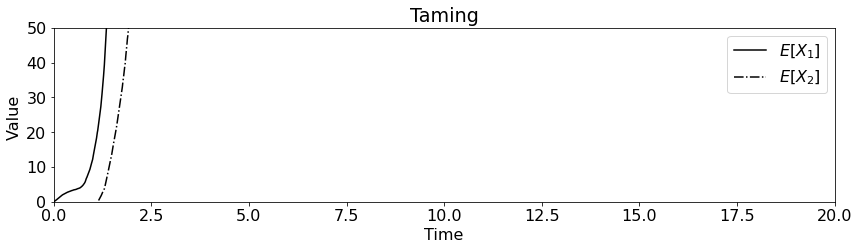

In [ ]:
### Convert to cpu and numpy
T=20
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(0, 50)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
# plt.savefig('x3-220406-vdp-e1-tam1.png', dpi=100)

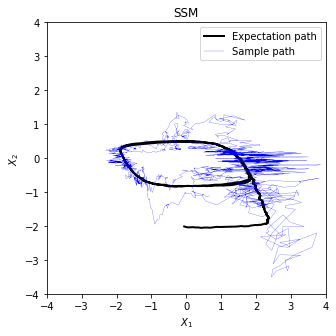

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[0,:,0], path_ssm_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p1-ssm.png', dpi=100)

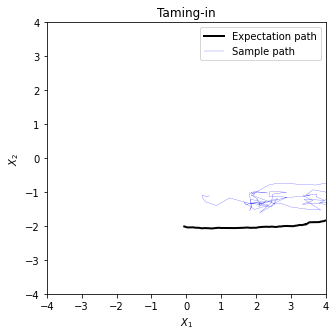

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming-in')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[0,:,0], path_tam_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p1-tam1.png', dpi=100)

### N(0,2) N(-2,2)

In [ ]:
T=40
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)



M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)

M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000
3000
4000


In [ ]:
particle_split_step_exact1

tensor([[[12.70968407, -1.07280022],
         [-1.46479531,  8.45099006],
         [-9.69933090, -3.12498704],
         ...,
         [-5.40714089, -5.01269870],
         [-1.33998883,  8.32071720],
         [ 3.99728576,  4.53016227]],

        [[ 1.84432234, -0.65663876],
         [ 1.73741935, -0.47772536],
         [ 1.41735617, -0.86163718],
         ...,
         [ 2.06368123, -0.54927485],
         [ 2.42154972, -1.20682883],
         [ 1.42266145, -0.38312008]]], dtype=torch.float64)

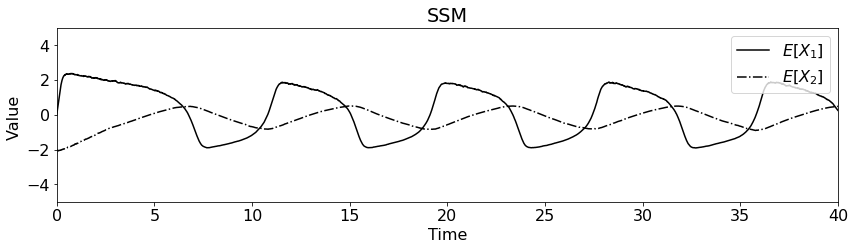

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p1.png', dpi=200)

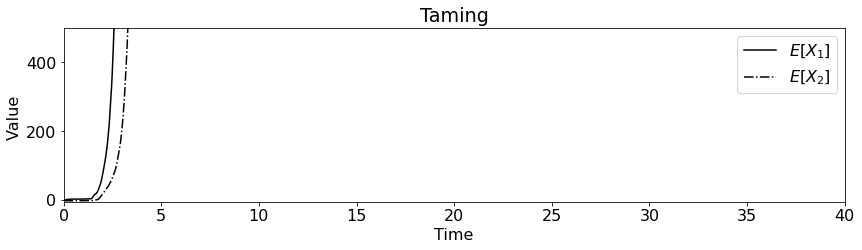

In [ ]:
### Convert to cpu and numpy
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,1000+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(-5, 500)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:1001,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:1001,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
plt.savefig('FIG-0531-vdp-p2.png', dpi=200)

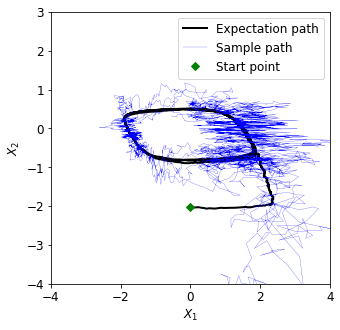

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase.png', dpi=200)

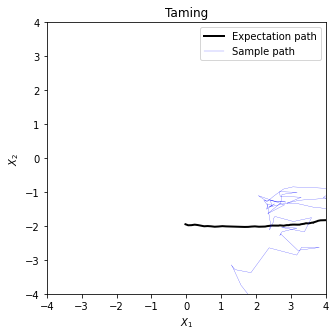

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[0,:,0], path_tam_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
# plt.savefig('x3-220406-vdp-p1-tam1.png', dpi=100)

### N(2,6) N(0,6)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(3,4)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-3,4)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):

    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000


In [ ]:
particle_taming_exact2[1]

tensor([[-0.88409362, -1.40664216],
        [-0.37127183, -1.44725287],
        [-0.25585077, -1.51103816],
        ...,
        [ 0.38000894, -1.30773256],
        [ 0.26081494, -1.12131947],
        [ 0.06443490, -1.31733953]], dtype=torch.float64)

In [ ]:
particle_taming_exact1[1,100:110],particle_taming_exact1[0,100:110],

In [ ]:
particle_taming_exact1[1,100:110],particle_taming_exact1[0,100:110],

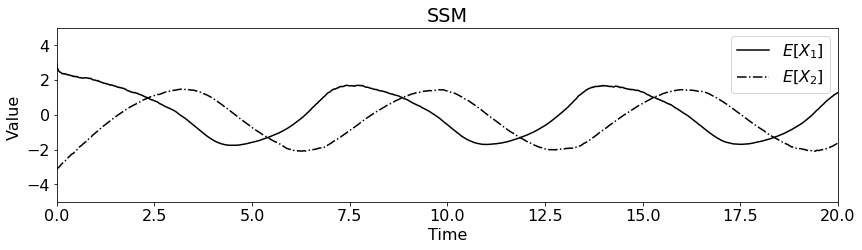

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ,loc='upper right') 
plt.savefig('x3-220406-vdp-e2-ssm.png', dpi=100)

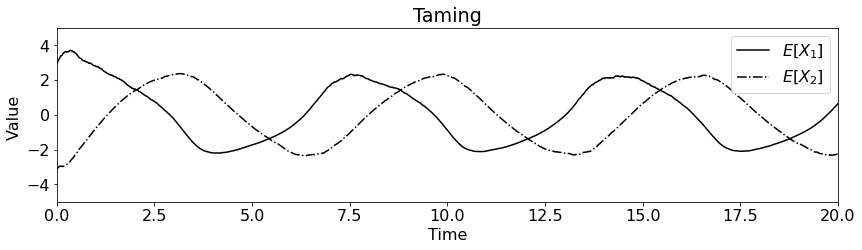

In [ ]:
### Convert to cpu and numpy
T=20
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ,loc='upper right') 
plt.savefig('x3-220406-vdp-e2-tam1.png', dpi=100)

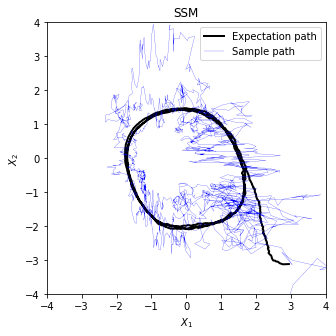

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[3,:,0], path_ssm_sample_cpu[3,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p2-ssm.png', dpi=100)

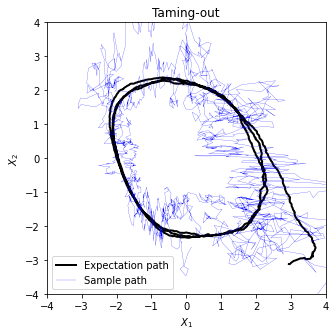

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming-out')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[3,:,0], path_tam_sample_cpu[3,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p2-tam1.png', dpi=100)

In [ ]:
path_tam_sample_cpu[0,:10,0],path_tam_sample_cpu[0,:10,1]

(array([5.12427098, 5.43822393, 5.10725694, 5.13508706, 5.02420507,
        4.63565401, 4.13959199, 4.21563146, 4.30705516, 4.23325736]),
 array([8.28457901, 8.16329554, 8.04274978, 7.92276603, 7.80351074,
        7.68496976, 7.5670999 , 7.44996063, 7.33373017, 7.21847345]))

In [ ]:
path_tam2_sample_cpu[0,:10,0],path_tam2_sample_cpu[0,:10,1]

(array([5.12427098, 5.44524874, 5.10758701, 5.13924734, 5.02928688,
        4.64295041, 4.15723698, 4.2547138 , 4.36521522, 4.304434  ]),
 array([8.28457901, 8.18505276, 8.08595321, 7.98768565, 7.88999829,
        7.793066  , 7.69707803, 7.60202441, 7.50762235, 7.4139024 ]))

In [ ]:
path_ssm_sample_cpu[0,:10,0],path_ssm_sample_cpu[0,:10,1]

(array([5.12427098, 5.14216767, 4.63484822, 4.50551189, 4.29888642,
        3.91912714, 3.4978408 , 3.53003302, 3.57597856, 3.50228973]),
 array([8.28457901, 7.42344806, 6.75516818, 6.23196082, 5.80533741,
        5.4501379 , 5.15259181, 4.90029024, 4.6782925 , 4.48095165]))

In [ ]:
path_tam2_sample_cpu[1,:10,0],path_tam2_sample_cpu[1,:10,1]

(array([1.21265405, 1.20648986, 1.21453052, 1.16423903, 1.19157923,
        1.27224067, 1.23819992, 1.24231048, 1.22169863, 1.19994297]),
 array([6.75985905, 6.67224988, 6.58551125, 6.49964471, 6.41457321,
        6.33045069, 6.24742489, 6.16525291, 6.0840104 , 6.00369715]))

In [ ]:
path_ssm_sample_cpu[3,:10,0],path_ssm_sample_cpu[3,:10,1]

(array([0.05362507, 0.23720515, 0.31909775, 0.41614871, 0.46461944,
        0.56220236, 0.59497314, 0.62221176, 0.63309389, 0.59608137]),
 array([-3.39775876, -3.18926402, -3.01978076, -2.87747114, -2.75653067,
        -2.65132848, -2.55882297, -2.47616037, -2.40162444, -2.33393216]))

In [ ]:
path_tam2_sample_cpu[3,:10,0],path_tam2_sample_cpu[3,:10,1]

(array([0.05362507, 0.15060463, 0.17163298, 0.22120453, 0.23659756,
        0.30692173, 0.32237352, 0.33696121, 0.33951056, 0.3004982 ]),
 array([-3.39775876, -3.34866321, -3.30024276, -3.25244342, -3.20535928,
        -3.15894642, -3.11324124, -3.06818872, -3.02384784, -2.98016494]))

In [ ]:
aaa=1
path_ssm_sample_cpu[aaa,:10,0],path_ssm_sample_cpu[aaa,:10,1],path_tam2_sample_cpu[aaa,:10,0],path_tam2_sample_cpu[aaa,:10,1],path_tam_sample_cpu[aaa,:10,0],path_tam_sample_cpu[aaa,:10,1],

(array([1.21265405, 1.25180926, 1.29478693, 1.2679591 , 1.31876226,
        1.42065126, 1.39379576, 1.40680949, 1.39124054, 1.37320836]),
 array([6.75985905, 6.19140718, 5.74111131, 5.37380604, 5.06837476,
        4.80848198, 4.58410275, 4.38781372, 4.21417666, 4.05925704]),
 array([1.21265405, 1.20648986, 1.21453052, 1.16423903, 1.19157923,
        1.27224067, 1.23819992, 1.24231048, 1.22169863, 1.19994297]),
 array([6.75985905, 6.67224988, 6.58551125, 6.49964471, 6.41457321,
        6.33045069, 6.24742489, 6.16525291, 6.0840104 , 6.00369715]),
 array([1.21265405, 1.24649643, 1.29434344, 1.28202405, 1.34849544,
        1.46833905, 1.46451588, 1.49992515, 1.50575064, 1.50617187]),
 array([6.75985905, 6.6421032 , 6.52542105, 6.40989429, 6.29556324,
        6.1825585 , 6.07092047, 5.9606866 , 5.85187525, 5.74458315]))

In [ ]:
aaa=2
path_ssm_sample_cpu[aaa,:10,0],path_ssm_sample_cpu[aaa,:10,1],path_tam2_sample_cpu[aaa,:10,0],path_tam2_sample_cpu[aaa,:10,1],path_tam_sample_cpu[aaa,:10,0],path_tam_sample_cpu[aaa,:10,1],

(array([2.33687359, 2.25484248, 2.2937495 , 2.24860839, 2.21961043,
        2.22521247, 2.12336541, 2.09295673, 2.00679215, 1.87542009]),
 array([7.17141258, 6.54362816, 6.04931774, 5.64782307, 5.31557285,
        5.03367749, 4.79066658, 4.57895512, 4.39216794, 4.22604867]),
 array([2.33687359, 0.11446134, 0.14899444, 0.14566344, 0.14743695,
        0.16378071, 0.13051934, 0.12688399, 0.09529143, 0.03783838]),
 array([ 7.17141258, -1.88118017, -1.881302  , -1.88138607, -1.88147826,
        -1.881564  , -1.88162992, -1.88172967, -1.88183006, -1.88196204]),
 array([2.33687359, 2.25902916, 2.30141583, 2.26077248, 2.23472726,
        2.24228327, 2.14680581, 2.12455861, 2.04638985, 1.92131705]),
 array([7.17141258, 7.05282984, 6.9351128 , 6.81842598, 6.7027928 ,
        6.58825553, 6.47483139, 6.36259056, 6.25157926, 6.14186286]))

The first step of the Taming v.2 is quiet wired, it suddenly break something, and then start to move normally
 

In [ ]:
path_ssm_sample_cpu[0,:,0]

array([-0.09546834, -0.09049836, -0.04489472, ...,  1.19975604,
        1.22015245,  1.19728678])

In [ ]:
path_tam_sample_cpu[0,:,0]

array([-0.09546834, -0.09048797, -0.04497465, ...,  1.22162712,
        1.24214993,  1.2191479 ])

In [ ]:
path_ssm=torch.randn(100,2, dtype=torch.float64)

In [ ]:
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()

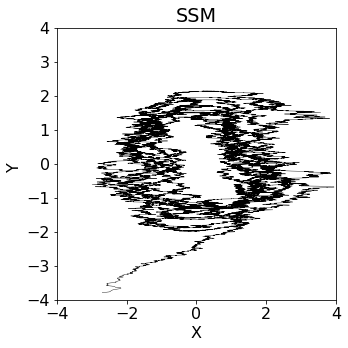

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[0,:,0], path_ssm_sample_cpu[0,:,1],color='black', linewidth=0.4)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

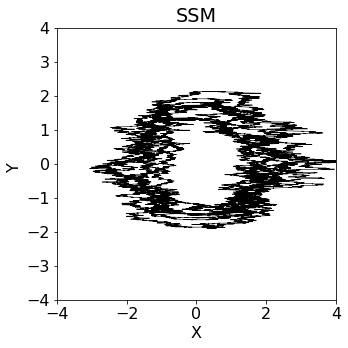

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[1,:,0], path_ssm_sample_cpu[1,:,1],color='black',linewidth=0.6)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

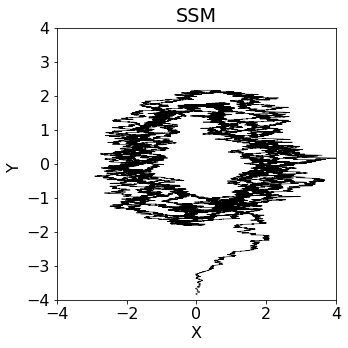

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[3,:,0], path_ssm_sample_cpu[3,:,1],color='black',linewidth=0.6)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

In [ ]:
a[:,1,:]

tensor([[ 0.69091289, -0.14337401],
        [ 0.28328026, -2.76063330],
        [-0.01396274, -1.21353213],
        [ 0.95413151, -1.54565877],
        [ 0.84787965, -1.84951934],
        [-0.34777950, -1.38346042],
        [ 0.30334550, -0.59684666],
        [-1.95773862, -0.50942256],
        [ 0.45640616, -0.02431654],
        [ 1.41002732, -4.05298716]], dtype=torch.float64)

In [ ]:
particle_split_step_exact1[1][:10]

tensor([[ 0.40454488, -0.83227914],
        [-0.22313729, -2.41626340],
        [-0.61556862, -0.19337399],
        [-0.90924098, -1.82521675],
        [-1.82353292, -1.99704146],
        [ 0.11064349, -1.72490523],
        [-0.69405520, -0.61186932],
        [ 0.08205527, -0.90854439],
        [ 1.48746884, -3.44912419],
        [ 0.15037643, -1.52661568]], dtype=torch.float64)

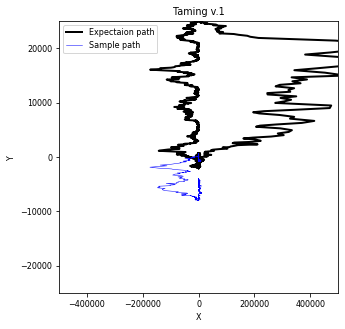

In [ ]:
### Plotting part T=40
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '8'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('Taming v.1')

plt.xlim(-500000, 500000)
plt.ylim(-25000, 25000)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[1,:,0], path_tam_sample_cpu[1,:,1],color='blue', linewidth=0.5)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectaion path',r'Sample path'] ) 
plt.savefig('220403-vdpa-p2-tam2v1.png', dpi=100)

### For different $N$. N(0,2) N(-2,2)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n

nnn=[30,100,500,1000]

torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]


particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact3=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact4=torch.zeros(2,N,2, dtype=torch.float64)



path_ssm1=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm1_sample=torch.zeros(10,M+1,2, dtype=torch.float64)
path_ssm2=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm2_sample=torch.zeros(10,M+1,2, dtype=torch.float64)
path_ssm3=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm3_sample=torch.zeros(10,M+1,2, dtype=torch.float64)
path_ssm4=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm4_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_split_step_exact3[1][i][0]=xxx000
    particle_split_step_exact4[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_split_step_exact3[1][i][1]=xxx000
    particle_split_step_exact4[1][i][1]=xxx000
 
xxx=0

ii=0
path_ssm1[ii]=torch.mean( particle_split_step_exact1[1][:nnn[0]],0 )
path_ssm1_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

path_ssm2[ii]=torch.mean( particle_split_step_exact2[1][:nnn[1]],0 )
path_ssm2_sample[:10,ii,:]=particle_split_step_exact2[1][:10]

path_ssm3[ii]=torch.mean( particle_split_step_exact3[1][:nnn[2]],0 )
path_ssm3_sample[:10,ii,:]=particle_split_step_exact3[1][:10]

path_ssm4[ii]=torch.mean( particle_split_step_exact4[1][:nnn[3]],0 )
path_ssm4_sample[:10,ii,:]=particle_split_step_exact4[1][:10]




torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,nnn[0])
    torch_ssm_method(particle_split_step_exact2,bm,h,T,nnn[1])
    torch_ssm_method(particle_split_step_exact3,bm,h,T,nnn[2])
    torch_ssm_method(particle_split_step_exact4,bm,h,T,nnn[3])




    path_ssm1[ii]=torch.mean( particle_split_step_exact1[1][:nnn[0]],0 )
    path_ssm1_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_ssm2[ii]=torch.mean( particle_split_step_exact2[1][:nnn[1]],0 )
    path_ssm2_sample[:10,ii,:]=particle_split_step_exact2[1][:10]

    path_ssm3[ii]=torch.mean( particle_split_step_exact3[1][:nnn[2]],0 )
    path_ssm3_sample[:10,ii,:]=particle_split_step_exact3[1][:10]

    path_ssm4[ii]=torch.mean( particle_split_step_exact4[1][:nnn[3]],0 )
    path_ssm4_sample[:10,ii,:]=particle_split_step_exact4[1][:10]



1000
2000


In [ ]:
path_ssm1

tensor([[ 0.02034420, -2.41393008],
        [ 0.08580125, -2.43707769],
        [ 0.24066522, -2.47423190],
        ...,
        [-1.08903292, -0.73241512],
        [-1.08049324, -0.77243720],
        [-1.07626991, -0.80400093]], dtype=torch.float64)

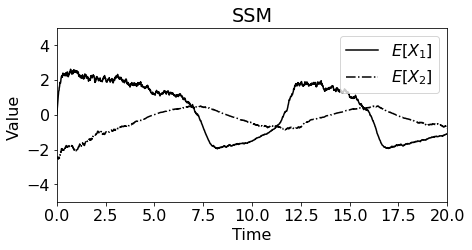

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm1.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p21.png', dpi=200)

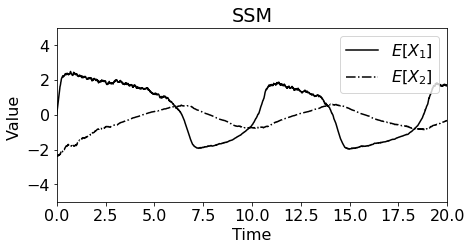

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm2.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p22.png', dpi=200)

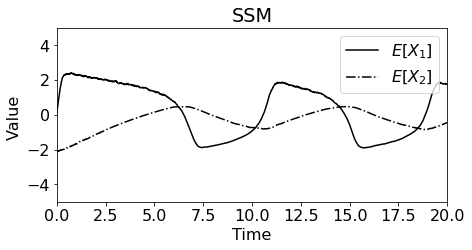

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm3.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p23.png', dpi=200)

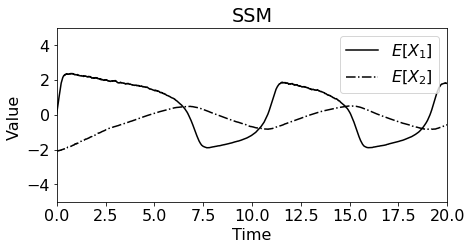

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm4.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p24.png', dpi=200)

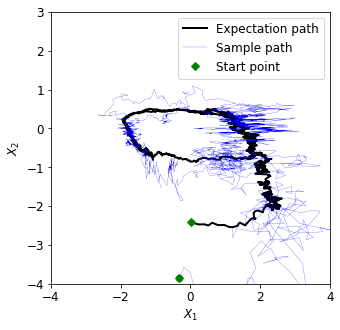

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm1_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm1.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase21.png', dpi=200)

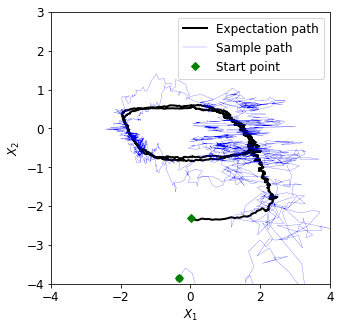

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm2_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm2.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase22.png', dpi=200)

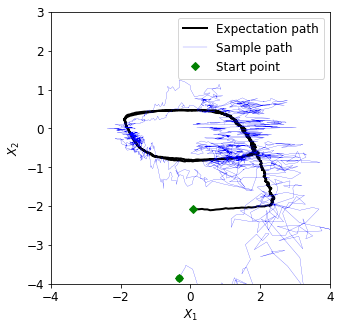

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm3_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm3.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase23.png', dpi=200)

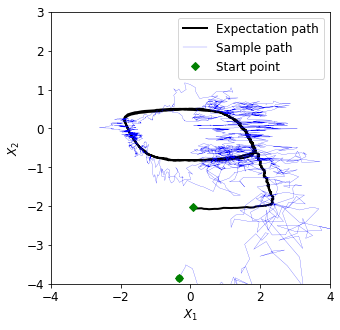

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm4_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm4.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase24.png', dpi=200)

In [ ]:
path_ssm_sample_cpu

array([[[ 0.        ,  0.        ],
        [-2.63272522,  0.01969484],
        [-2.0915867 , -0.25857155],
        ...,
        [ 2.22605944, -0.24807841],
        [ 2.41138334, -0.26358387],
        [ 2.05705311, -0.23822291]],

       [[ 0.        ,  0.        ],
        [-1.33122227, -1.43431652],
        [-1.16371824, -1.52960916],
        ...,
        [ 0.7864661 , -0.50776316],
        [ 0.93305241, -0.55362656],
        [ 0.9771919 , -0.56015961]],

       [[ 0.        ,  0.        ],
        [-3.03640777, -4.1192831 ],
        [-2.10978275, -3.91127196],
        ...,
        [ 1.63423218, -0.82938795],
        [ 1.92757442, -0.94776595],
        [ 2.10115686, -0.98570367]],

       ...,

       [[ 0.        ,  0.        ],
        [-0.33434584,  1.23845199],
        [-0.31012985,  0.76755089],
        ...,
        [ 1.59859118, -0.40555776],
        [ 1.8464407 , -0.44222807],
        [ 2.07903719, -0.46329912]],

       [[ 0.        ,  0.        ],
        [ 0.27799295, -2.69

# v.3


In [ ]:
def torch_make_brownian_motion(bm,h):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm), dtype=torch.float64, device='cuda')
    return(0)

def torch_make_brownian_motion_md(bm,h,d):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm),d, dtype=torch.float64, device='cuda')
    return(0)


def f3(a): #a: N x N x 2
    nn=len(a)
    result=(torch.sum(a**2,2).reshape(nn,nn,1))*a
    return(-torch.mean(result,1))
#     return(result)
    


def f3_tam(a,mma): #a: N x N x 2
    nn=len(a)
    result=(torch.sum(a**2,2).reshape(nn,nn,1))*a
    result=result/(1+mma*torch.abs(result))

    return(-torch.mean(result,1))

    

def df3(aa):
    nn=len(aa)
    dd=len(aa[0,0])
    df=torch.matmul(aa.reshape(nn,nn,dd,1),aa.reshape(nn,nn,1,dd))*(-2)
    _norm2=-torch.sum(aa**2,2).reshape(nn,nn,1)
    df+=_norm2.reshape(nn,nn,1,1)*torch.eye(dd)
    
    return(torch.mean(df,1))

def du3(aa):
    nn=len(aa)
    ddd=len(aa[0])
    df=torch.zeros((nn,ddd,ddd), dtype=torch.float64, device='cuda')   
    df[:,0,0]=-aa[:,0]**2
    return(df)


def sigma3(aa):
    sig=aa.detach().clone()
    return(sig)

def b3(aa):
    bb=aa.detach().clone()    
    return(bb)



def torch_ssm_method(x,bm,h,T,N):  #x : 2xNx2
    mu=4.0
    # N=len(x[0])
    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    mul_1=torch.tensor([1,-1])
    ddd=len(x[1,0])
    mul_2=torch.eye(ddd, dtype=torch.float64,  device='cuda')
    dd=len(x[1,0])
    
    bb_matrix=torch.tensor([[mu,-mu],[1/mu,0.]], dtype=torch.float64,  device='cuda'  )
    sig_matrix=torch.tensor([1.,0.] ,  dtype=torch.float64, device='cuda' )
    sig_y=torch.tensor([1.,1.] ,  dtype=torch.float64, device='cuda' )
    
    pd=True
    while pd:
        # sample_vre = torch.reshape(y[1,:N],(N,1,dd))
        
        # nominator_tmp = sample_vre-y[1,:N]
#         nom_tmp =  -nominator_tmp**3 
        
        # vy =  f3(nominator_tmp)      
        
        uy = y.detach().clone()
        uy[1,:N,1]=0
        
        # FF=(vy*h-h*uy[1,:N]**3-y[1,:N]+x[1,:N])
        
        FF=( -(mu*h/3*uy[1,:N]**3)-y[1,:N]+x[1,:N])
        
        # d_f=df3(nominator_tmp)
        
        # d_uy= du3( uy[1,:N])
        # d_FF=h*(d_f+d_uy)-mul_2

        
        d_FF=torch.zeros((N,2,2), dtype=torch.float64, device='cuda')-mul_2
        d_FF[:,0,0]+=-mu*uy[1,:N,0]**2*h

        inv_d_FF=torch.linalg.inv(d_FF)
        FF=FF.reshape(N,dd,1)
        
        inv_d_FF_x_FF=torch.matmul(inv_d_FF,FF)
        
        y[1,:N]+= -inv_d_FF_x_FF.reshape(N,dd)
        
        if torch.max(torch.abs(inv_d_FF_x_FF))<=sqrth:  
            pd=False
            #print( max(np.abs(fovergprime)) )
    
     
    
    dWt=bm[:N]-x[0,:N]
    x[0,:N]=bm[:N]
#     x[1,:N]=y[1,:N]+bb*h + sigg*dWt
    x[1,:N]=y[1,:N]+(torch.matmul(bb_matrix,y[1,:N].reshape(N,2,1))*h).reshape(N,2)+(sig_matrix+(sig_y*y[1,:N]))*dWt
    return(0)



def torch_taming_method(x,bm,h,T,N):  #x : 2xNx2
    mu=4.0
    # N=len(x[0])
    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    mul_1=torch.tensor([1,-1])
    mul_2=torch.tensor([[1,0],[0,1]])
    mma=M**(-alpha)
    bb_matrix=torch.tensor([[mu,-mu],[1/mu,0.]], dtype=torch.float64,  device='cuda'  )
    sig_matrix=torch.tensor([1.,0.] ,  dtype=torch.float64, device='cuda' )
    sig_y=torch.tensor([1.,1.] ,  dtype=torch.float64, device='cuda' )
    
    sample_vre = torch.reshape(x[1,:N],(N,1,2))    
    nominator_tmp = sample_vre-x[1,:N]
  
    vx =  torch.zeros((N,2), dtype=torch.float64, device='cuda')
    
    
    vx[:,0]+=-mu*x[1,:N,0]**3/3
    
 

    
    dWt=bm[:N]-x[0,:N]
    x[0,:N]=bm[:N]
    sigx=(sig_matrix+(sig_y*x[1,:N]))
    x[1,:N]+=h*vx/(1+mma*torch.abs(vx))+(torch.matmul(bb_matrix,x[1,:N].reshape(N,2,1))*h).reshape(N,2)+(sigx)*dWt
    return(0)





## Phase graphs

### N(0,1) N(-2,1)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000


In [ ]:
particle_split_step_exact1

tensor([[[  9.43485531,  -4.38620383],
         [-10.16543128,  -1.45493599],
         [ -4.00352088,  -1.29496385],
         ...,
         [ -6.05767587,  -0.45546998],
         [ -3.27196966,  -1.10589262],
         [  2.02864408,  -4.87930606]],

        [[  2.06760785,  -0.27238210],
         [  0.98728483,  -0.57952555],
         [  2.12608697,  -1.04264784],
         ...,
         [  1.03453363,  -0.13952421],
         [  1.98781250,  -0.46254874],
         [  1.95850887,  -0.51591219]]], dtype=torch.float64)

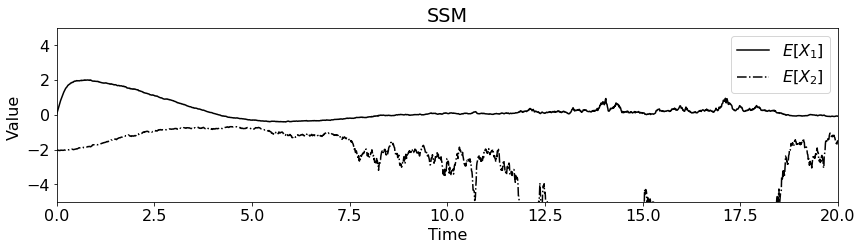

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
# plt.savefig('x3-220406-vdp-e1-ssm.png', dpi=100)

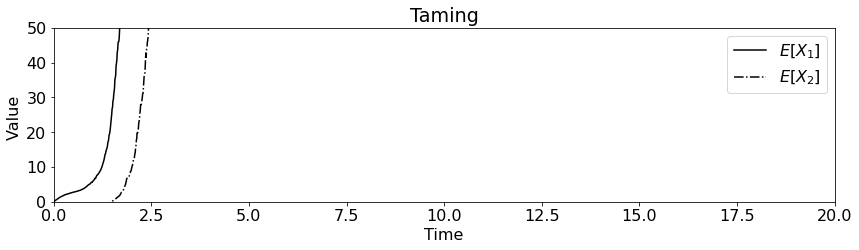

In [ ]:
### Convert to cpu and numpy
T=20
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(0, 50)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
# plt.savefig('x3-220406-vdp-e1-tam1.png', dpi=100)

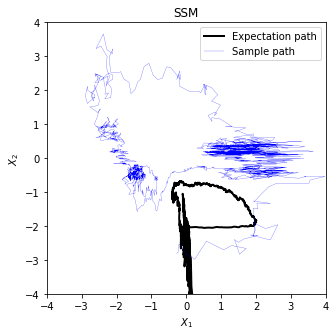

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[0,:,0], path_ssm_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p1-ssm.png', dpi=100)

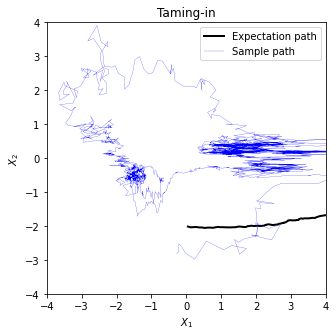

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming-in')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[0,:,0], path_tam_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p1-tam1.png', dpi=100)

### N(0,2) N(-2,2)

In [ ]:
T=40
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)



M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)

M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000
3000
4000


In [ ]:
particle_split_step_exact1

tensor([[[12.70968407, -1.07280022],
         [-1.46479531,  8.45099006],
         [-9.69933090, -3.12498704],
         ...,
         [-5.40714089, -5.01269870],
         [-1.33998883,  8.32071720],
         [ 3.99728576,  4.53016227]],

        [[ 1.84432234, -0.65663876],
         [ 1.73741935, -0.47772536],
         [ 1.41735617, -0.86163718],
         ...,
         [ 2.06368123, -0.54927485],
         [ 2.42154972, -1.20682883],
         [ 1.42266145, -0.38312008]]], dtype=torch.float64)

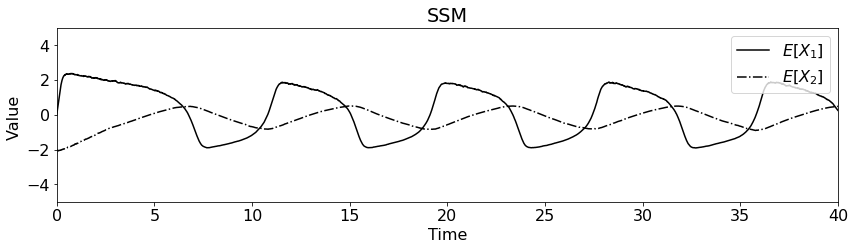

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p1.png', dpi=200)

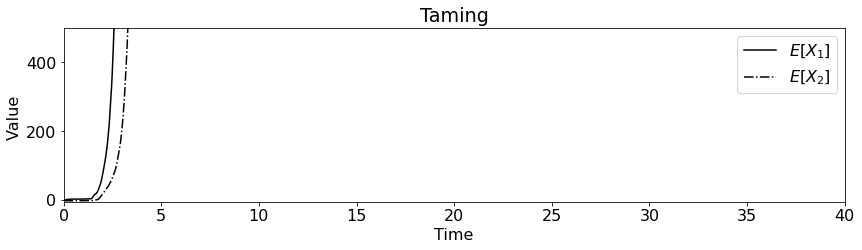

In [ ]:
### Convert to cpu and numpy
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,1000+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(-5, 500)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:1001,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:1001,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ) 
plt.savefig('FIG-0531-vdp-p2.png', dpi=200)

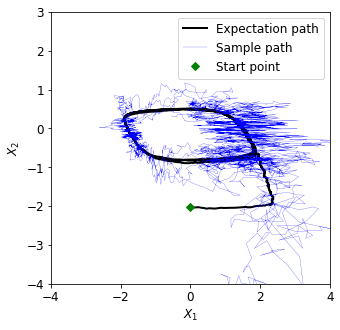

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase.png', dpi=200)

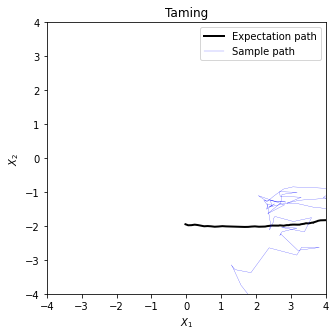

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[0,:,0], path_tam_sample_cpu[0,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
# plt.savefig('x3-220406-vdp-p1-tam1.png', dpi=100)

### N(2,6) N(0,6)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n


torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]



particle_taming_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_taming_exact2=torch.zeros(2,N,2,  dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N,2, dtype=torch.float64)

path_ssm=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm_sample=torch.zeros(10,M+1,2, dtype=torch.float64)

path_tam=torch.zeros(M+1,2, dtype=torch.float64)
path_tam_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(3,4)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_euler_exact1[1][i][0]=xxx000
        
    xxx000=np.random.normal(-3,4)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][1]=xxx000
    particle_taming_exact2[1][i][1]=xxx000
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_euler_exact1[1][i][1]=xxx000
 
xxx=0


path_ssm[0]=torch.mean( particle_split_step_exact1[1],0 )
path_ssm_sample[:,0,:]=particle_split_step_exact1[1][:10]

path_tam[0]=torch.mean( particle_taming_exact1[1],0 )
path_tam_sample[:,0,:]=particle_taming_exact1[1][:10]


torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):

    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_taming_method(particle_taming_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    path_ssm[ii]=torch.mean( particle_split_step_exact1[1],0 )
    path_ssm_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_tam[ii]=torch.mean( particle_taming_exact1[1],0 )
    path_tam_sample[:10,ii,:]=particle_taming_exact1[1][:10]



1000
2000


In [ ]:
particle_taming_exact2[1]

tensor([[-0.88409362, -1.40664216],
        [-0.37127183, -1.44725287],
        [-0.25585077, -1.51103816],
        ...,
        [ 0.38000894, -1.30773256],
        [ 0.26081494, -1.12131947],
        [ 0.06443490, -1.31733953]], dtype=torch.float64)

In [ ]:
particle_taming_exact1[1,100:110],particle_taming_exact1[0,100:110],

In [ ]:
particle_taming_exact1[1,100:110],particle_taming_exact1[0,100:110],

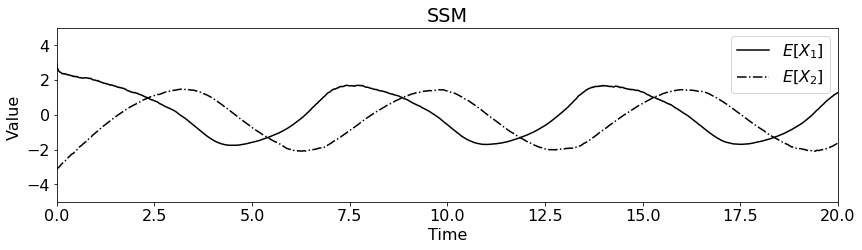

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ,loc='upper right') 
plt.savefig('x3-220406-vdp-e2-ssm.png', dpi=100)

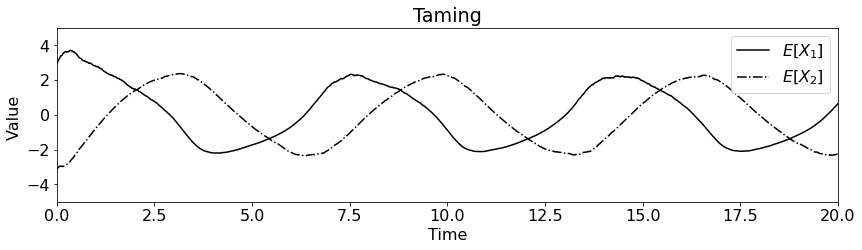

In [ ]:
### Convert to cpu and numpy
T=20
path_tam_cpu=path_tam.to( "cpu")
path_tam_cpu=path_tam_cpu.numpy()


### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('Taming')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_tam_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_tam_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'] ,loc='upper right') 
plt.savefig('x3-220406-vdp-e2-tam1.png', dpi=100)

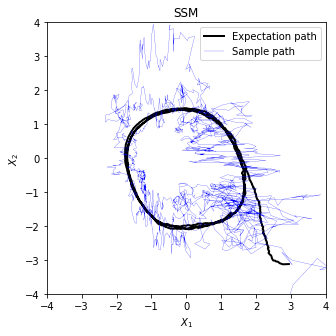

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[3,:,0], path_ssm_sample_cpu[3,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p2-ssm.png', dpi=100)

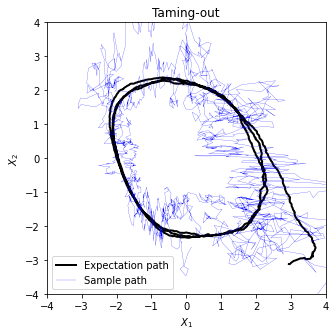

In [ ]:
### Plotting part
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '10'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
plt.title('Taming-out')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[3,:,0], path_tam_sample_cpu[3,:,1],color='blue', linewidth=0.2)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectation path',r'Sample path'] ) 
plt.savefig('x3-220406-vdp-p2-tam1.png', dpi=100)

In [ ]:
path_tam_sample_cpu[0,:10,0],path_tam_sample_cpu[0,:10,1]

(array([5.12427098, 5.43822393, 5.10725694, 5.13508706, 5.02420507,
        4.63565401, 4.13959199, 4.21563146, 4.30705516, 4.23325736]),
 array([8.28457901, 8.16329554, 8.04274978, 7.92276603, 7.80351074,
        7.68496976, 7.5670999 , 7.44996063, 7.33373017, 7.21847345]))

In [ ]:
path_tam2_sample_cpu[0,:10,0],path_tam2_sample_cpu[0,:10,1]

(array([5.12427098, 5.44524874, 5.10758701, 5.13924734, 5.02928688,
        4.64295041, 4.15723698, 4.2547138 , 4.36521522, 4.304434  ]),
 array([8.28457901, 8.18505276, 8.08595321, 7.98768565, 7.88999829,
        7.793066  , 7.69707803, 7.60202441, 7.50762235, 7.4139024 ]))

In [ ]:
path_ssm_sample_cpu[0,:10,0],path_ssm_sample_cpu[0,:10,1]

(array([5.12427098, 5.14216767, 4.63484822, 4.50551189, 4.29888642,
        3.91912714, 3.4978408 , 3.53003302, 3.57597856, 3.50228973]),
 array([8.28457901, 7.42344806, 6.75516818, 6.23196082, 5.80533741,
        5.4501379 , 5.15259181, 4.90029024, 4.6782925 , 4.48095165]))

In [ ]:
path_tam2_sample_cpu[1,:10,0],path_tam2_sample_cpu[1,:10,1]

(array([1.21265405, 1.20648986, 1.21453052, 1.16423903, 1.19157923,
        1.27224067, 1.23819992, 1.24231048, 1.22169863, 1.19994297]),
 array([6.75985905, 6.67224988, 6.58551125, 6.49964471, 6.41457321,
        6.33045069, 6.24742489, 6.16525291, 6.0840104 , 6.00369715]))

In [ ]:
path_ssm_sample_cpu[3,:10,0],path_ssm_sample_cpu[3,:10,1]

(array([0.05362507, 0.23720515, 0.31909775, 0.41614871, 0.46461944,
        0.56220236, 0.59497314, 0.62221176, 0.63309389, 0.59608137]),
 array([-3.39775876, -3.18926402, -3.01978076, -2.87747114, -2.75653067,
        -2.65132848, -2.55882297, -2.47616037, -2.40162444, -2.33393216]))

In [ ]:
path_tam2_sample_cpu[3,:10,0],path_tam2_sample_cpu[3,:10,1]

(array([0.05362507, 0.15060463, 0.17163298, 0.22120453, 0.23659756,
        0.30692173, 0.32237352, 0.33696121, 0.33951056, 0.3004982 ]),
 array([-3.39775876, -3.34866321, -3.30024276, -3.25244342, -3.20535928,
        -3.15894642, -3.11324124, -3.06818872, -3.02384784, -2.98016494]))

In [ ]:
aaa=1
path_ssm_sample_cpu[aaa,:10,0],path_ssm_sample_cpu[aaa,:10,1],path_tam2_sample_cpu[aaa,:10,0],path_tam2_sample_cpu[aaa,:10,1],path_tam_sample_cpu[aaa,:10,0],path_tam_sample_cpu[aaa,:10,1],

(array([1.21265405, 1.25180926, 1.29478693, 1.2679591 , 1.31876226,
        1.42065126, 1.39379576, 1.40680949, 1.39124054, 1.37320836]),
 array([6.75985905, 6.19140718, 5.74111131, 5.37380604, 5.06837476,
        4.80848198, 4.58410275, 4.38781372, 4.21417666, 4.05925704]),
 array([1.21265405, 1.20648986, 1.21453052, 1.16423903, 1.19157923,
        1.27224067, 1.23819992, 1.24231048, 1.22169863, 1.19994297]),
 array([6.75985905, 6.67224988, 6.58551125, 6.49964471, 6.41457321,
        6.33045069, 6.24742489, 6.16525291, 6.0840104 , 6.00369715]),
 array([1.21265405, 1.24649643, 1.29434344, 1.28202405, 1.34849544,
        1.46833905, 1.46451588, 1.49992515, 1.50575064, 1.50617187]),
 array([6.75985905, 6.6421032 , 6.52542105, 6.40989429, 6.29556324,
        6.1825585 , 6.07092047, 5.9606866 , 5.85187525, 5.74458315]))

In [ ]:
aaa=2
path_ssm_sample_cpu[aaa,:10,0],path_ssm_sample_cpu[aaa,:10,1],path_tam2_sample_cpu[aaa,:10,0],path_tam2_sample_cpu[aaa,:10,1],path_tam_sample_cpu[aaa,:10,0],path_tam_sample_cpu[aaa,:10,1],

(array([2.33687359, 2.25484248, 2.2937495 , 2.24860839, 2.21961043,
        2.22521247, 2.12336541, 2.09295673, 2.00679215, 1.87542009]),
 array([7.17141258, 6.54362816, 6.04931774, 5.64782307, 5.31557285,
        5.03367749, 4.79066658, 4.57895512, 4.39216794, 4.22604867]),
 array([2.33687359, 0.11446134, 0.14899444, 0.14566344, 0.14743695,
        0.16378071, 0.13051934, 0.12688399, 0.09529143, 0.03783838]),
 array([ 7.17141258, -1.88118017, -1.881302  , -1.88138607, -1.88147826,
        -1.881564  , -1.88162992, -1.88172967, -1.88183006, -1.88196204]),
 array([2.33687359, 2.25902916, 2.30141583, 2.26077248, 2.23472726,
        2.24228327, 2.14680581, 2.12455861, 2.04638985, 1.92131705]),
 array([7.17141258, 7.05282984, 6.9351128 , 6.81842598, 6.7027928 ,
        6.58825553, 6.47483139, 6.36259056, 6.25157926, 6.14186286]))

The first step of the Taming v.2 is quiet wired, it suddenly break something, and then start to move normally
 

In [ ]:
path_ssm_sample_cpu[0,:,0]

array([-0.09546834, -0.09049836, -0.04489472, ...,  1.19975604,
        1.22015245,  1.19728678])

In [ ]:
path_tam_sample_cpu[0,:,0]

array([-0.09546834, -0.09048797, -0.04497465, ...,  1.22162712,
        1.24214993,  1.2191479 ])

In [ ]:
path_ssm=torch.randn(100,2, dtype=torch.float64)

In [ ]:
path_ssm_cpu=path_ssm.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()

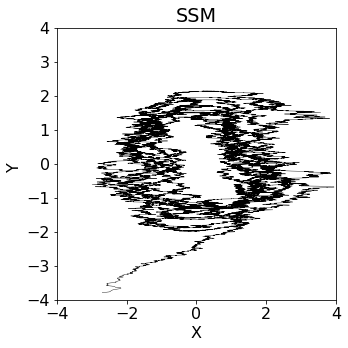

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[0,:,0], path_ssm_sample_cpu[0,:,1],color='black', linewidth=0.4)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

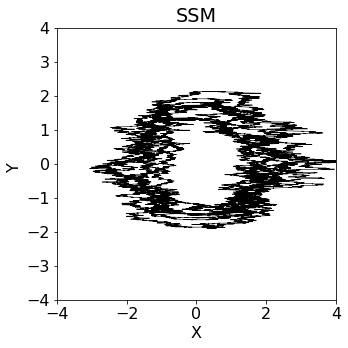

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[1,:,0], path_ssm_sample_cpu[1,:,1],color='black',linewidth=0.6)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

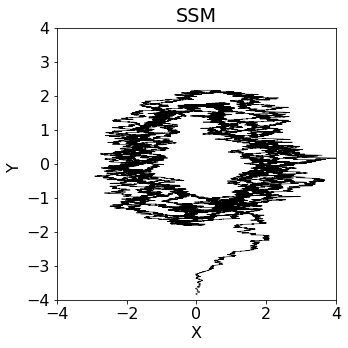

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '16'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_sample_cpu[3,:,0], path_ssm_sample_cpu[3,:,1],color='black',linewidth=0.6)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
# plt.legend([(a1),(a2) ],[r'$E[X]$',r'$E[Y]$'] ) 
# plt.savefig('220403-vdpa-p2.png', dpi=100)

In [ ]:
a[:,1,:]

tensor([[ 0.69091289, -0.14337401],
        [ 0.28328026, -2.76063330],
        [-0.01396274, -1.21353213],
        [ 0.95413151, -1.54565877],
        [ 0.84787965, -1.84951934],
        [-0.34777950, -1.38346042],
        [ 0.30334550, -0.59684666],
        [-1.95773862, -0.50942256],
        [ 0.45640616, -0.02431654],
        [ 1.41002732, -4.05298716]], dtype=torch.float64)

In [ ]:
particle_split_step_exact1[1][:10]

tensor([[ 0.40454488, -0.83227914],
        [-0.22313729, -2.41626340],
        [-0.61556862, -0.19337399],
        [-0.90924098, -1.82521675],
        [-1.82353292, -1.99704146],
        [ 0.11064349, -1.72490523],
        [-0.69405520, -0.61186932],
        [ 0.08205527, -0.90854439],
        [ 1.48746884, -3.44912419],
        [ 0.15037643, -1.52661568]], dtype=torch.float64)

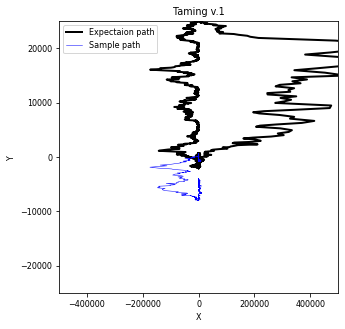

In [ ]:
### Plotting part T=40
path_tam_sample_cpu=path_tam_sample.to( "cpu")
path_tam_sample_cpu=path_tam_sample_cpu.numpy()


axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '8'  
plt.xlabel('X')  
plt.ylabel('Y ') 
plt.title('Taming v.1')

plt.xlim(-500000, 500000)
plt.ylim(-25000, 25000)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_tam_cpu[:,0], path_tam_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_tam_sample_cpu[1,:,0], path_tam_sample_cpu[1,:,1],color='blue', linewidth=0.5)
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'Expectaion path',r'Sample path'] ) 
plt.savefig('220403-vdpa-p2-tam2v1.png', dpi=100)

### For different $N$. N(0,2) N(-2,2)

In [ ]:
T=20
d=2
h=1e-2
n=1000
N=n

nnn=[30,100,500,1000]

torch.manual_seed(3141)


T=20
M=int(T/h)





#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N,2, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]


particle_split_step_exact1=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact3=torch.zeros(2,N,2, dtype=torch.float64)
particle_split_step_exact4=torch.zeros(2,N,2, dtype=torch.float64)



path_ssm1=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm1_sample=torch.zeros(10,M+1,2, dtype=torch.float64)
path_ssm2=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm2_sample=torch.zeros(10,M+1,2, dtype=torch.float64)
path_ssm3=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm3_sample=torch.zeros(10,M+1,2, dtype=torch.float64)
path_ssm4=torch.zeros(M+1,2, dtype=torch.float64)
path_ssm4_sample=torch.zeros(10,M+1,2, dtype=torch.float64)



#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_taming_exact1[1][i][0]=xxx000
    particle_taming_exact2[1][i][0]=xxx000
    particle_split_step_exact2[1][i][0]=xxx000
    particle_split_step_exact1[1][i][0]=xxx000
    particle_split_step_exact3[1][i][0]=xxx000
    particle_split_step_exact4[1][i][0]=xxx000
        
    xxx000=np.random.normal(-2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_split_step_exact2[1][i][1]=xxx000
    particle_split_step_exact1[1][i][1]=xxx000
    particle_split_step_exact3[1][i][1]=xxx000
    particle_split_step_exact4[1][i][1]=xxx000
 
xxx=0

ii=0
path_ssm1[ii]=torch.mean( particle_split_step_exact1[1][:nnn[0]],0 )
path_ssm1_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

path_ssm2[ii]=torch.mean( particle_split_step_exact2[1][:nnn[1]],0 )
path_ssm2_sample[:10,ii,:]=particle_split_step_exact2[1][:10]

path_ssm3[ii]=torch.mean( particle_split_step_exact3[1][:nnn[2]],0 )
path_ssm3_sample[:10,ii,:]=particle_split_step_exact3[1][:10]

path_ssm4[ii]=torch.mean( particle_split_step_exact4[1][:nnn[3]],0 )
path_ssm4_sample[:10,ii,:]=particle_split_step_exact4[1][:10]




torch.manual_seed(31)
T=20
M=int(T/h)
for ii in range(1,M+1):
# for ii in range(1,1+1):
    if ii%1000==0: print(ii)
    
    torch_make_brownian_motion_md(bm,h,2)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,nnn[0])
    torch_ssm_method(particle_split_step_exact2,bm,h,T,nnn[1])
    torch_ssm_method(particle_split_step_exact3,bm,h,T,nnn[2])
    torch_ssm_method(particle_split_step_exact4,bm,h,T,nnn[3])




    path_ssm1[ii]=torch.mean( particle_split_step_exact1[1][:nnn[0]],0 )
    path_ssm1_sample[:10,ii,:]=particle_split_step_exact1[1][:10]

    path_ssm2[ii]=torch.mean( particle_split_step_exact2[1][:nnn[1]],0 )
    path_ssm2_sample[:10,ii,:]=particle_split_step_exact2[1][:10]

    path_ssm3[ii]=torch.mean( particle_split_step_exact3[1][:nnn[2]],0 )
    path_ssm3_sample[:10,ii,:]=particle_split_step_exact3[1][:10]

    path_ssm4[ii]=torch.mean( particle_split_step_exact4[1][:nnn[3]],0 )
    path_ssm4_sample[:10,ii,:]=particle_split_step_exact4[1][:10]



1000
2000


In [ ]:
path_ssm1

tensor([[ 0.02034420, -2.41393008],
        [ 0.08580125, -2.43707769],
        [ 0.24066522, -2.47423190],
        ...,
        [-1.08903292, -0.73241512],
        [-1.08049324, -0.77243720],
        [-1.07626991, -0.80400093]], dtype=torch.float64)

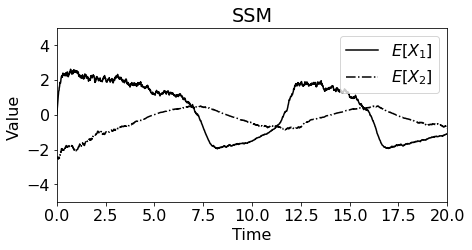

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm1.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p21.png', dpi=200)

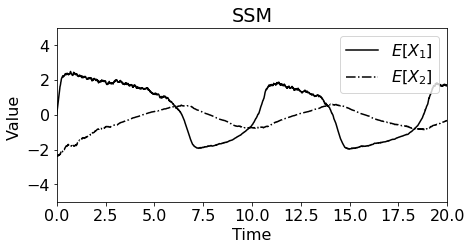

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm2.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p22.png', dpi=200)

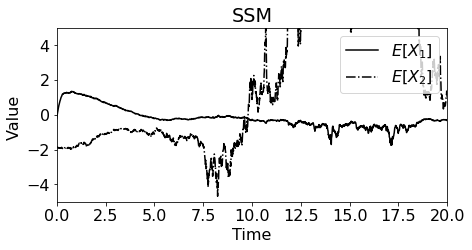

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm3.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p23.png', dpi=200)

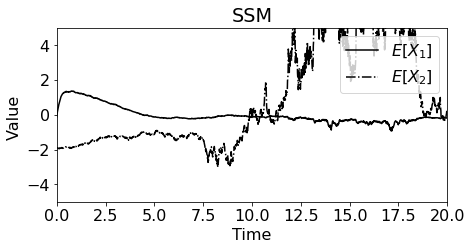

In [ ]:
### Convert to cpu and numpy
path_ssm_cpu=path_ssm4.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()
T=20

### Plotting part

axiss=[]
for i in range(0,M+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (7,3.2)
plt.rcParams['font.size'] = '16'  
plt.xlabel('Time')  
plt.ylabel('Value ') 
plt.title('SSM')

plt.xlim(0, T)
plt.ylim(-5, 5)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2) ],[r'$E[X_1]$',r'$E[X_2]$'],loc='upper right' ) 
plt.savefig('FIG-0531-vdp-p24.png', dpi=200)

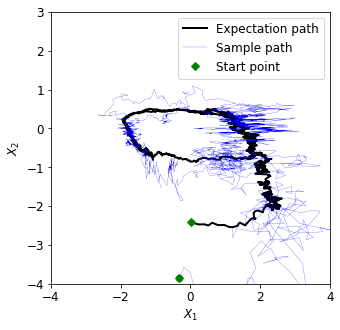

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm1_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm1.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase21.png', dpi=200)

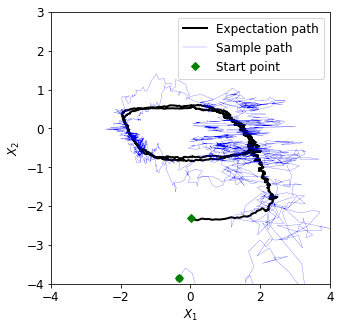

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm2_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm2.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase22.png', dpi=200)

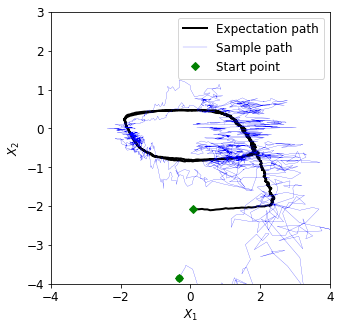

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm3_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm3.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase23.png', dpi=200)

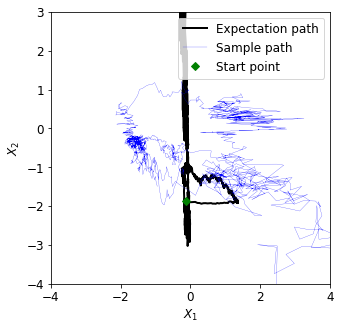

In [ ]:
### Plotting part
path_ssm_sample_cpu=path_ssm4_sample.to( "cpu")
path_ssm_sample_cpu=path_ssm_sample_cpu.numpy()
path_ssm_cpu=path_ssm4.to( "cpu")
path_ssm_cpu=path_ssm_cpu.numpy()



axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.size'] = '12'  
plt.xlabel(r'$X_1$')  
plt.ylabel(r'$X_2$') 
# plt.title('SSM')

plt.xlim(-4, 4)
plt.ylim(-4, 3)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')
# a1,=plt.plot( axiss, path_ssm_cpu[:,0],color='black')
a1,=plt.plot( path_ssm_cpu[:,0], path_ssm_cpu[:,1],color='black', linewidth=2.0)
a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='blue', linewidth=0.2)
# plt.scatter( path_ssm_cpu[0,0], path_ssm_cpu[0,1],color='green',s=40)
plt.scatter(  path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],color='green',s=40)
a3,=plt.plot( path_ssm_cpu[0,0], path_ssm_cpu[0,1],'D',color='g')
plt.plot( path_ssm_sample_cpu[2,0,0], path_ssm_sample_cpu[2,0,1],'D',color='g')
# a2,=plt.plot( path_ssm_sample_cpu[2,:,0], path_ssm_sample_cpu[2,:,1],color='red', linewidth=0.2)
# a2,=plt.plot( axiss, path_ssm_cpu[:,1],'g-.',color='black')
plt.legend([(a1),(a2),(a3) ],[r'Expectation path',r'Sample path','Start point'], loc='upper right' ) 
plt.savefig('FIG-0531-vdp-phase24.png', dpi=200)

In [ ]:
path_ssm_sample_cpu

array([[[ 0.        ,  0.        ],
        [-2.63272522,  0.01969484],
        [-2.0915867 , -0.25857155],
        ...,
        [ 2.22605944, -0.24807841],
        [ 2.41138334, -0.26358387],
        [ 2.05705311, -0.23822291]],

       [[ 0.        ,  0.        ],
        [-1.33122227, -1.43431652],
        [-1.16371824, -1.52960916],
        ...,
        [ 0.7864661 , -0.50776316],
        [ 0.93305241, -0.55362656],
        [ 0.9771919 , -0.56015961]],

       [[ 0.        ,  0.        ],
        [-3.03640777, -4.1192831 ],
        [-2.10978275, -3.91127196],
        ...,
        [ 1.63423218, -0.82938795],
        [ 1.92757442, -0.94776595],
        [ 2.10115686, -0.98570367]],

       ...,

       [[ 0.        ,  0.        ],
        [-0.33434584,  1.23845199],
        [-0.31012985,  0.76755089],
        ...,
        [ 1.59859118, -0.40555776],
        [ 1.8464407 , -0.44222807],
        [ 2.07903719, -0.46329912]],

       [[ 0.        ,  0.        ],
        [ 0.27799295, -2.69